In [ ]:
import os
import numpy as np
from PIL import Image # Used for opening the TIFF file
import random
import cv2 # Used for saving the colorized PNG
import sys # Used for printing errors to stderr

# --- Function to colorize a segmentation map ---
def colorize_seg_map(seg_map: np.ndarray, palette: dict = None) -> np.ndarray:
    """
    Colorizes a segmentation map using random RGB colors for unique IDs.

    Args:
        seg_map: A 2D NumPy array representing the segmentation map, where each
                 unique integer value corresponds to a segment ID.
        palette: An optional dictionary mapping segment IDs to RGB color tuples
                 (e.g., {1: (255, 0, 0), 2: (0, 255, 0)}). If None, a random
                 palette is generated for the unique IDs present in the map.

    Returns:
        A 3D NumPy array (height, width, 3) representing the colorized segmentation map
        in RGB format (uint8). Background (ID 0) is left black.
    """
    # Ensure the segmentation map is a NumPy array
    if not isinstance(seg_map, np.ndarray):
        seg_map = np.array(seg_map)

    # Create an empty RGB image of the same shape as the segmentation map
    colorful_seg_map = np.zeros((*seg_map.shape, 3), dtype=np.uint8)

    # Get the unique segment IDs present in the map
    unique_ids = np.unique(seg_map)

    # Generate a palette if none is provided
    if palette is None:
        palette = {}
        # Generate a random color for each unique ID (excluding background 0)
        for seg_id in unique_ids:
            if seg_id == 0:
                continue # Skip background
            # Generate random integer colors between 0 and 255
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            palette[seg_id] = color
    else:
        # Validate provided palette contains colors for unique IDs (optional but good practice)
        # For simplicity, we'll assume the provided palette is valid for now.
        pass # Add validation logic here if needed

    # Apply colors to the segmentation map
    for seg_id, color in palette.items():
        # Ensure we only color IDs present in the map and not the background (ID 0)
        if seg_id != 0 and seg_id in unique_ids:
             # Use boolean indexing to assign the color to all pixels with this segment ID
            colorful_seg_map[seg_map == seg_id, :] = color

    return colorful_seg_map

# --- Function to process a single TIFF segmentation file ---
def process_segmentation_file(input_filepath: str, output_base_path: str) -> bool:
    """
    Converts a TIFF segmentation mask to a NumPy array (.npy) and
    a colorized PNG image (.png).

    Args:
        input_filepath: Path to the input .tif segmentation file.
        output_base_path: Base path for saving the output files (without extension).
                          The .npy and .png extensions will be added automatically.

    Returns:
        True if processing was successful, False otherwise.
    """
    try:
        # Open the .tif file using Pillow
        with Image.open(input_filepath) as img:
            # Convert image to a NumPy array
            # Ensure dtype is appropriate for segmentation IDs (e.g., uint16 or int32 if IDs are large)
            # For typical masks, uint8 might suffice, but uint16 is safer.
            img_array = np.array(img, dtype=np.uint16) # Use uint16 for potentially larger IDs

            # Generate colorized mask
            color_mask = colorize_seg_map(img_array)

            # Define output file paths
            output_npy_path = f"{output_base_path}.npy"
            output_png_path = f"{output_base_path}.png"

            # Save the NumPy array as a .npy file
            np.save(output_npy_path, img_array)
            # Save the colorized mask as a .png file using OpenCV
            # OpenCV saves in BGR format, so we need to convert RGB to BGR
            cv2.imwrite(output_png_path, cv2.cvtColor(color_mask, cv2.COLOR_RGB2BGR))

            # print(f"Processed {os.path.basename(input_filepath)}") # Optional: print success per file
        return True
    except FileNotFoundError:
        print(f"Error: Input file not found at {input_filepath}", file=sys.stderr)
        return False
    except Exception as e:
        print(f"An error occurred processing {os.path.basename(input_filepath)}: {e}", file=sys.stderr)
        return False

# --- Function to process all segmentation files in a directory ---
def process_segmentation_directory(input_dir: str, output_dir: str):
    """
    Processes all .tif segmentation mask files in an input directory,
    converting each to a .npy array and a colorized .png image,
    and saves them in the output directory.

    Args:
        input_dir: Path to the directory containing input .tif files.
        output_dir: Path to the directory where output .npy and .png files will be saved.
    """
    print(f"Processing segmentation masks from: {input_dir}")
    print(f"Saving processed files to: {output_dir}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # List all entries in the input directory
    entries = os.listdir(input_dir)
    print(f"Found {len(entries)} entries in {input_dir}")

    processed_count = 0
    failed_count = 0

    # Iterate through each entry
    for entry_name in entries:
        input_filepath = os.path.join(input_dir, entry_name)

        # Check if it's a file and ends with .tif (case-insensitive)
        if os.path.isfile(input_filepath) and entry_name.lower().endswith('.tif'):
            try:
                # Get the base filename without extension
                base_name = os.path.splitext(entry_name)[0]
                # Define the base path for the output files (without extension)
                output_base_path = os.path.join(output_dir, base_name)

                # Process the file
                print(f"Processing {entry_name}...") # Print before processing
                if process_segmentation_file(input_filepath, output_base_path):
                    processed_count += 1
                else:
                    failed_count += 1

            except Exception as e:
                # Catch potential errors during path manipulation or naming
                print(f"An unexpected error occurred processing entry {entry_name}: {e}", file=sys.stderr)
                failed_count += 1
        # else:
            # Optional: print messages for ignored entries (e.g., directories, non-tif files)
            # print(f"Skipping {entry_name} (not a .tif file or not a file)")


    print("-" * 40)
    print(f"Processing complete for {input_dir}")
    print(f"Successfully processed: {processed_count}")
    print(f"Failed to process: {failed_count}")
    print("-" * 40)


# --- Main Execution Block (suitable for a notebook cell) ---

# Define the base paths for input and output
# Assuming the structure is like ./data/DSB2018/original/test/masks/*.tif
base_input_path = "../data/DSB2018/original"
base_output_path = "../data/DSB2018/visual" # This seems to be where you want the output

# Define the splits to process (e.g., 'test', 'train')
# Based on your original code, it seems you were processing the 'test' split.
# You can add 'train' if needed.
splits = ['train', 'test', 'val'] # Add 'train' here if you want to process train masks too

# Process each split
for split in splits:
    # Construct the full input directory path for the masks
    # Assuming masks are in a 'masks' subdirectory within the split
    input_masks_dir = os.path.join(base_input_path, split, 'masks') # Assuming a 'masks' subdir
    # Construct the full output directory path
    output_processed_dir = os.path.join(base_output_path, split, 'masks') # Saving processed masks here

    # Check if the input directory exists before processing
    if os.path.isdir(input_masks_dir):
        process_segmentation_directory(input_masks_dir, output_processed_dir)
    else:
        print(f"\n--- Skipping {split} split ---")
        print(f"Input masks directory not found: {input_masks_dir}")
        print("-" * 40)

print("\nAll specified splits processed.")



In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage import measure
from matplotlib import colors
import cv2
from tqdm import tqdm
import random

# Define the four colors (index 0 is background)
FOUR_COLORS = ['black', 'red', 'green', 'blue', 'yellow']

def create_adjacency_graph(label_img):
    """
    Create an adjacency graph based on a labeled instance image.
    Each node is a nucleus instance, and edges represent adjacency relationships.
    """
    regions = measure.regionprops(label_img)
    adjacency_graph = nx.Graph()

    for region in regions:
        adjacency_graph.add_node(region.label)

    for region in regions:
        coords = region.coords
        for y, x in coords:
            for dy, dx in [(-5, 0), (5, 0), (0, -5), (0, 5)]:
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < label_img.shape[0] and 0 <= nx_ < label_img.shape[1]:
                    neighbor_label = label_img[ny, nx_]
                    if neighbor_label > 0 and neighbor_label != region.label:
                        adjacency_graph.add_edge(region.label, neighbor_label)

    return adjacency_graph

def color_cells(label_img, max_colors=4):
    """
    Apply greedy graph coloring to nuclei instances.
    Reassign nodes with colors >= max_colors randomly.
    """
    adjacency_graph = create_adjacency_graph(label_img)
    coloring = nx.coloring.greedy_color(adjacency_graph, strategy="largest_first")

    reassigned_count = 0
    for node, color_index in coloring.items():
        if color_index >= max_colors:
            coloring[node] = random.randint(0, max_colors - 1)
            reassigned_count += 1

    color_index_map = np.zeros(label_img.shape, dtype=np.uint8)
    for label, color_index in coloring.items():
        color_index_map[label_img == label] = color_index + 1  # 0 is background

    return color_index_map, reassigned_count

def visualize_color_map(color_index_map):
    """
    Generate a visualization image from the color index map.
    """
    cmap = colors.ListedColormap(FOUR_COLORS)
    norm = colors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], ncolors=5)
    return cmap(norm(color_index_map))

def process_all_datasets(input_root, output_root):
    """
    Traverse 'train', 'val', 'test' folders and apply four-color encoding.
    Save index maps and visualizations to output_root.
    """
    stages = ['test']
    total_reassigned = 0

    for stage in stages:
        input_dir = os.path.join(input_root, stage)
        save_dir = os.path.join(output_root, stage)
        visual_dir = os.path.join(output_root, stage, 'visual')

        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(visual_dir, exist_ok=True)

        npy_files = [f for f in os.listdir(input_dir) if f.endswith('.npy')]

        for f in tqdm(npy_files, desc=f"Processing {stage}"):
            f_name = os.path.splitext(f)[0]
            label_img = np.load(os.path.join(input_dir, f)).astype(np.uint16)

            color_index_map, reassigned_count = color_cells(label_img)
            total_reassigned += reassigned_count

            # Save indexed color mask as grayscale PNG
            cv2.imwrite(os.path.join(save_dir, f"{f_name}.png"), color_index_map)

            # Save visualization as color PNG
            vis_img = visualize_color_map(color_index_map)
            plt.imsave(os.path.join(visual_dir, f"{f_name}.png"), vis_img)

    print(f"\n✅ Total reassigned cells across all datasets: {total_reassigned}")

# === Run this section below ===

input_dir = "/data1/zhangye/FCIS/data/PanNuke/inst"
output_dir = "/data1/zhangye/FCIS/data/PanNuke/fcis_inst"

process_all_datasets(input_dir, output_dir)


Processing test: 100%|██████████| 2722/2722 [07:51<00:00,  5.77it/s]


✅ Total reassigned cells across all datasets: 0


In [25]:
import os
import numpy as np
from skimage import measure
import networkx as nx
import yaml
from tqdm import tqdm

def create_adjacency_graph(label_img):
    """
    Create an adjacency graph based on a labeled instance image.
    Each node is a nucleus instance, and edges represent adjacency relationships.
    """
    regions = measure.regionprops(label_img)
    adjacency_graph = nx.Graph()

    for region in regions:
        adjacency_graph.add_node(region.label)

    for region in regions:
        coords = region.coords
        for y, x in coords:
            for dy, dx in [(-5, 0), (5, 0), (0, -5), (0, 5)]:
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < label_img.shape[0] and 0 <= nx_ < label_img.shape[1]:
                    neighbor_label = label_img[ny, nx_]
                    if neighbor_label > 0 and neighbor_label != region.label:
                        adjacency_graph.add_edge(region.label, neighbor_label)

    return adjacency_graph

def save_adjacency_map_to_yaml(graph, file_path):
    """
    Save a networkx graph as an adjacency map to YAML.
    
    Args:
        graph (networkx.Graph): The graph representing adjacency relationships.
        file_path (str): Path to save the YAML file.
    """
    adjacency_map = {int(node): list(map(int, graph.neighbors(node))) for node in graph.nodes}
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'w') as f:
        yaml.dump(adjacency_map, f, default_flow_style=False, sort_keys=False)

# === Input and Output Paths ===
inst_root = "/data1/zhangye/FCIS/data/PanNuke/inst"
save_root = "/data1/zhangye/FCIS/data/PanNuke/adjacency"
stages = ['test']

# === Process All Files ===
for stage in stages:
    input_dir = os.path.join(inst_root, stage)
    output_dir = os.path.join(save_root, stage)
    os.makedirs(output_dir, exist_ok=True)

    file_list = [f for f in os.listdir(input_dir) if f.endswith(".npy")]

    for f in tqdm(file_list, desc=f"Processing {stage}"):
        f_name = os.path.splitext(f)[0]
        print('f name', f_name)
        mask = np.load(os.path.join(input_dir, f)).astype(dtype=np.uint16)
        # print(mask)
        graph = create_adjacency_graph(mask)
        output_file = os.path.join(output_dir, f"{f_name}.yaml")
        save_adjacency_map_to_yaml(graph, output_file)

print("✅ All adjacency maps saved successfully.")



Processing test:   0%|          | 0/2722 [00:00<?, ?it/s]

f name 5179


Processing test:   0%|          | 2/2722 [00:00<11:02,  4.10it/s]

f name 5180
f name 5181


Processing test:   0%|          | 3/2722 [00:00<09:06,  4.97it/s]

f name 5182


Processing test:   0%|          | 4/2722 [00:00<09:23,  4.82it/s]

f name 5183


Processing test:   0%|          | 5/2722 [00:01<10:13,  4.43it/s]

f name 5184


Processing test:   0%|          | 7/2722 [00:01<10:15,  4.41it/s]

f name 5185
f name 5186


Processing test:   0%|          | 9/2722 [00:02<09:25,  4.80it/s]

f name 5187
f name 5188


Processing test:   0%|          | 10/2722 [00:02<08:43,  5.18it/s]

f name 5199


Processing test:   0%|          | 11/2722 [00:02<09:17,  4.86it/s]

f name 5200
f name 5201


Processing test:   1%|          | 14/2722 [00:02<08:26,  5.35it/s]

f name 5202
f name 5203


Processing test:   1%|          | 17/2722 [00:03<06:42,  6.73it/s]

f name 5204
f name 5205
f name 5206


Processing test:   1%|          | 19/2722 [00:03<06:27,  6.98it/s]

f name 5207
f name 5208


Processing test:   1%|          | 23/2722 [00:03<04:06, 10.93it/s]

f name 5219
f name 5220
f name 5221
f name 5222


Processing test:   1%|          | 25/2722 [00:04<05:26,  8.26it/s]

f name 5223
f name 5224
f name 5225


Processing test:   1%|          | 28/2722 [00:04<06:24,  7.01it/s]

f name 5226
f name 5227
f name 5228


Processing test:   1%|          | 31/2722 [00:04<05:03,  8.87it/s]

f name 5239
f name 5240


Processing test:   1%|          | 32/2722 [00:05<05:49,  7.69it/s]

f name 5241


Processing test:   1%|          | 34/2722 [00:05<06:51,  6.53it/s]

f name 5242
f name 5243


Processing test:   1%|▏         | 35/2722 [00:05<07:48,  5.74it/s]

f name 5244
f name 5245
f name 5246


Processing test:   1%|▏         | 38/2722 [00:06<05:54,  7.56it/s]

f name 5247


Processing test:   1%|▏         | 40/2722 [00:06<06:27,  6.93it/s]

f name 5248
f name 5259


Processing test:   2%|▏         | 42/2722 [00:06<07:24,  6.03it/s]

f name 5260
f name 5261
f name 5262


Processing test:   2%|▏         | 45/2722 [00:07<05:46,  7.73it/s]

f name 5263
f name 5264


Processing test:   2%|▏         | 48/2722 [00:07<04:54,  9.10it/s]

f name 5265
f name 5266
f name 5267


Processing test:   2%|▏         | 49/2722 [00:07<05:04,  8.78it/s]

f name 5268


Processing test:   2%|▏         | 51/2722 [00:07<06:45,  6.58it/s]

f name 5279
f name 5280


Processing test:   2%|▏         | 53/2722 [00:08<08:49,  5.04it/s]

f name 5281
f name 5282


Processing test:   2%|▏         | 54/2722 [00:08<11:30,  3.86it/s]

f name 5283


Processing test:   2%|▏         | 56/2722 [00:09<09:10,  4.84it/s]

f name 5284
f name 5285


Processing test:   2%|▏         | 58/2722 [00:09<09:00,  4.93it/s]

f name 5286
f name 5287


Processing test:   2%|▏         | 59/2722 [00:09<09:18,  4.77it/s]

f name 5288


Processing test:   2%|▏         | 60/2722 [00:10<09:53,  4.48it/s]

f name 5299


Processing test:   2%|▏         | 61/2722 [00:10<10:57,  4.05it/s]

f name 5300


Processing test:   2%|▏         | 62/2722 [00:10<10:58,  4.04it/s]

f name 5301
f name 5302


Processing test:   2%|▏         | 64/2722 [00:10<09:21,  4.74it/s]

f name 5303


Processing test:   2%|▏         | 65/2722 [00:11<09:28,  4.67it/s]

f name 5304


Processing test:   2%|▏         | 66/2722 [00:11<10:05,  4.39it/s]

f name 5305


Processing test:   2%|▏         | 67/2722 [00:11<09:53,  4.47it/s]

f name 5306


Processing test:   2%|▏         | 68/2722 [00:11<09:46,  4.53it/s]

f name 5307
f name 5308


Processing test:   3%|▎         | 71/2722 [00:12<08:43,  5.06it/s]

f name 5319
f name 5320


Processing test:   3%|▎         | 73/2722 [00:12<08:33,  5.16it/s]

f name 5321
f name 5322


Processing test:   3%|▎         | 76/2722 [00:13<05:46,  7.63it/s]

f name 5323
f name 5324
f name 5325


Processing test:   3%|▎         | 77/2722 [00:13<07:29,  5.89it/s]

f name 5326


Processing test:   3%|▎         | 78/2722 [00:13<09:05,  4.84it/s]

f name 5327


Processing test:   3%|▎         | 80/2722 [00:14<08:23,  5.25it/s]

f name 5328
f name 5339
f name 5340


Processing test:   3%|▎         | 83/2722 [00:14<04:39,  9.45it/s]

f name 5341
f name 5342


Processing test:   3%|▎         | 85/2722 [00:14<05:56,  7.39it/s]

f name 5343
f name 5344
f name 5345


Processing test:   3%|▎         | 87/2722 [00:14<07:04,  6.20it/s]

f name 5346


Processing test:   3%|▎         | 88/2722 [00:15<07:36,  5.77it/s]

f name 5347


Processing test:   3%|▎         | 89/2722 [00:15<08:25,  5.21it/s]

f name 5348


Processing test:   3%|▎         | 92/2722 [00:15<07:13,  6.07it/s]

f name 5359
f name 5360
f name 5361


Processing test:   3%|▎         | 93/2722 [00:16<08:00,  5.47it/s]

f name 5362


Processing test:   3%|▎         | 95/2722 [00:16<08:04,  5.42it/s]

f name 5363
f name 5364


Processing test:   4%|▎         | 97/2722 [00:16<06:50,  6.40it/s]

f name 5365
f name 5366


Processing test:   4%|▎         | 100/2722 [00:17<05:17,  8.25it/s]

f name 5367
f name 5368
f name 5379


Processing test:   4%|▍         | 103/2722 [00:17<05:02,  8.67it/s]

f name 5380
f name 5381
f name 5382


Processing test:   4%|▍         | 105/2722 [00:17<05:25,  8.04it/s]

f name 5383
f name 5384


Processing test:   4%|▍         | 107/2722 [00:17<05:34,  7.82it/s]

f name 5385
f name 5386


Processing test:   4%|▍         | 108/2722 [00:18<06:19,  6.88it/s]

f name 5387
f name 5388


Processing test:   4%|▍         | 111/2722 [00:18<07:10,  6.06it/s]

f name 5399
f name 5400


Processing test:   4%|▍         | 112/2722 [00:18<07:38,  5.69it/s]

f name 5401


Processing test:   4%|▍         | 113/2722 [00:19<08:34,  5.07it/s]

f name 5402


Processing test:   4%|▍         | 116/2722 [00:19<06:41,  6.50it/s]

f name 5403
f name 5404
f name 5405


Processing test:   4%|▍         | 117/2722 [00:19<07:54,  5.49it/s]

f name 5406


Processing test:   4%|▍         | 118/2722 [00:19<08:17,  5.23it/s]

f name 5407


Processing test:   4%|▍         | 119/2722 [00:20<08:31,  5.09it/s]

f name 5408
f name 5419


Processing test:   4%|▍         | 122/2722 [00:20<07:13,  6.00it/s]

f name 5420
f name 5421


Processing test:   5%|▍         | 124/2722 [00:21<07:46,  5.57it/s]

f name 5422
f name 5423
f name 5424


Processing test:   5%|▍         | 128/2722 [00:21<05:14,  8.25it/s]

f name 5425
f name 5426
f name 5427


Processing test:   5%|▍         | 129/2722 [00:21<06:42,  6.45it/s]

f name 5428


Processing test:   5%|▍         | 131/2722 [00:22<08:22,  5.15it/s]

f name 5439
f name 5440


Processing test:   5%|▍         | 132/2722 [00:22<07:54,  5.46it/s]

f name 5441


Processing test:   5%|▍         | 133/2722 [00:22<10:46,  4.00it/s]

f name 5442


Processing test:   5%|▍         | 134/2722 [00:23<11:26,  3.77it/s]

f name 5443


Processing test:   5%|▍         | 135/2722 [00:23<12:05,  3.57it/s]

f name 5444


Processing test:   5%|▍         | 136/2722 [00:23<11:15,  3.83it/s]

f name 5445


Processing test:   5%|▌         | 137/2722 [00:23<11:43,  3.68it/s]

f name 5446


Processing test:   5%|▌         | 138/2722 [00:24<11:11,  3.85it/s]

f name 5447


Processing test:   5%|▌         | 139/2722 [00:24<10:38,  4.05it/s]

f name 5448


Processing test:   5%|▌         | 141/2722 [00:24<09:37,  4.47it/s]

f name 5459
f name 5460


Processing test:   5%|▌         | 143/2722 [00:25<09:58,  4.31it/s]

f name 5461
f name 5462


Processing test:   5%|▌         | 145/2722 [00:25<07:27,  5.76it/s]

f name 5463
f name 5464


Processing test:   5%|▌         | 146/2722 [00:25<09:42,  4.42it/s]

f name 5465


Processing test:   5%|▌         | 148/2722 [00:26<08:43,  4.91it/s]

f name 5466
f name 5467
f name 5468


Processing test:   6%|▌         | 152/2722 [00:26<06:36,  6.48it/s]

f name 5479
f name 5480
f name 5481


Processing test:   6%|▌         | 155/2722 [00:27<05:28,  7.82it/s]

f name 5482
f name 5483
f name 5484
f name 5485


Processing test:   6%|▌         | 157/2722 [00:27<05:53,  7.25it/s]

f name 5486


Processing test:   6%|▌         | 159/2722 [00:27<06:45,  6.32it/s]

f name 5487
f name 5488


Processing test:   6%|▌         | 161/2722 [00:28<06:19,  6.75it/s]

f name 5499
f name 5500


Processing test:   6%|▌         | 162/2722 [00:28<06:24,  6.66it/s]

f name 5501


Processing test:   6%|▌         | 163/2722 [00:28<07:08,  5.97it/s]

f name 5502


Processing test:   6%|▌         | 164/2722 [00:28<08:09,  5.23it/s]

f name 5503


Processing test:   6%|▌         | 165/2722 [00:29<09:40,  4.40it/s]

f name 5504


Processing test:   6%|▌         | 166/2722 [00:29<09:50,  4.33it/s]

f name 5505


Processing test:   6%|▌         | 168/2722 [00:29<09:13,  4.61it/s]

f name 5506
f name 5507


Processing test:   6%|▌         | 169/2722 [00:29<09:26,  4.50it/s]

f name 5508


Processing test:   6%|▋         | 171/2722 [00:30<08:54,  4.78it/s]

f name 5519
f name 5520


Processing test:   6%|▋         | 173/2722 [00:30<07:02,  6.04it/s]

f name 5521
f name 5522


Processing test:   6%|▋         | 175/2722 [00:30<05:58,  7.11it/s]

f name 5523
f name 5524
f name 5525


Processing test:   7%|▋         | 179/2722 [00:31<04:45,  8.90it/s]

f name 5526
f name 5527
f name 5528


Processing test:   7%|▋         | 181/2722 [00:31<03:59, 10.61it/s]

f name 5539
f name 5540


Processing test:   7%|▋         | 183/2722 [00:31<05:20,  7.92it/s]

f name 5541
f name 5542
f name 5543


Processing test:   7%|▋         | 185/2722 [00:32<05:20,  7.91it/s]

f name 5544


Processing test:   7%|▋         | 188/2722 [00:32<05:21,  7.88it/s]

f name 5545
f name 5546
f name 5547


Processing test:   7%|▋         | 189/2722 [00:32<05:53,  7.17it/s]

f name 5548


Processing test:   7%|▋         | 191/2722 [00:33<06:19,  6.67it/s]

f name 5559
f name 5560


Processing test:   7%|▋         | 192/2722 [00:33<07:09,  5.89it/s]

f name 5561


Processing test:   7%|▋         | 193/2722 [00:33<08:08,  5.18it/s]

f name 5562


Processing test:   7%|▋         | 194/2722 [00:33<09:02,  4.66it/s]

f name 5563


Processing test:   7%|▋         | 195/2722 [00:34<09:46,  4.31it/s]

f name 5564
f name 5565


Processing test:   7%|▋         | 197/2722 [00:34<09:31,  4.42it/s]

f name 5566
f name 5567


Processing test:   7%|▋         | 200/2722 [00:34<07:17,  5.77it/s]

f name 5568
f name 5579
f name 5580


Processing test:   7%|▋         | 204/2722 [00:35<04:51,  8.64it/s]

f name 5581
f name 5582
f name 5583


Processing test:   8%|▊         | 206/2722 [00:35<04:38,  9.02it/s]

f name 5584
f name 5585


Processing test:   8%|▊         | 208/2722 [00:35<05:15,  7.96it/s]

f name 5586
f name 5587


Processing test:   8%|▊         | 209/2722 [00:35<05:11,  8.06it/s]

f name 5588
f name 5599


Processing test:   8%|▊         | 211/2722 [00:36<04:52,  8.58it/s]

f name 5600


Processing test:   8%|▊         | 213/2722 [00:36<05:57,  7.01it/s]

f name 5601
f name 5602
f name 5603


Processing test:   8%|▊         | 216/2722 [00:36<05:39,  7.39it/s]

f name 5604
f name 5605


Processing test:   8%|▊         | 218/2722 [00:37<07:17,  5.73it/s]

f name 5606
f name 5607


Processing test:   8%|▊         | 219/2722 [00:37<07:17,  5.72it/s]

f name 5608


Processing test:   8%|▊         | 220/2722 [00:37<08:32,  4.89it/s]

f name 5619
f name 5620


Processing test:   8%|▊         | 224/2722 [00:38<05:43,  7.28it/s]

f name 5621
f name 5622
f name 5623
f name 5624


Processing test:   8%|▊         | 228/2722 [00:38<04:34,  9.10it/s]

f name 5625
f name 5626
f name 5627


Processing test:   8%|▊         | 230/2722 [00:38<04:41,  8.85it/s]

f name 5628
f name 5639


Processing test:   9%|▊         | 232/2722 [00:38<04:22,  9.47it/s]

f name 5640
f name 5641
f name 5642


Processing test:   9%|▊         | 236/2722 [00:39<03:26, 12.03it/s]

f name 5643
f name 5644
f name 5645


Processing test:   9%|▊         | 238/2722 [00:39<04:21,  9.50it/s]

f name 5646
f name 5647


Processing test:   9%|▉         | 240/2722 [00:39<04:41,  8.83it/s]

f name 5648
f name 5659


Processing test:   9%|▉         | 242/2722 [00:40<06:21,  6.51it/s]

f name 5660
f name 5661


Processing test:   9%|▉         | 243/2722 [00:40<07:17,  5.66it/s]

f name 5662


Processing test:   9%|▉         | 244/2722 [00:40<07:57,  5.19it/s]

f name 5663


Processing test:   9%|▉         | 245/2722 [00:41<08:22,  4.93it/s]

f name 5664


Processing test:   9%|▉         | 246/2722 [00:41<08:30,  4.85it/s]

f name 5665


Processing test:   9%|▉         | 248/2722 [00:41<08:44,  4.71it/s]

f name 5666
f name 5667


Processing test:   9%|▉         | 250/2722 [00:41<07:05,  5.80it/s]

f name 5668
f name 5679


Processing test:   9%|▉         | 251/2722 [00:42<09:54,  4.16it/s]

f name 5680


Processing test:   9%|▉         | 252/2722 [00:42<11:36,  3.55it/s]

f name 5681


Processing test:   9%|▉         | 253/2722 [00:43<12:27,  3.30it/s]

f name 5682


Processing test:   9%|▉         | 254/2722 [00:43<12:50,  3.20it/s]

f name 5683


Processing test:   9%|▉         | 255/2722 [00:43<12:45,  3.22it/s]

f name 5684


Processing test:   9%|▉         | 257/2722 [00:44<11:25,  3.59it/s]

f name 5685
f name 5686


Processing test:   9%|▉         | 258/2722 [00:44<10:01,  4.09it/s]

f name 5687


Processing test:  10%|▉         | 260/2722 [00:44<08:29,  4.83it/s]

f name 5688
f name 5699


Processing test:  10%|▉         | 261/2722 [00:45<08:13,  4.99it/s]

f name 5700
f name 5701


Processing test:  10%|▉         | 263/2722 [00:45<06:23,  6.42it/s]

f name 5702


Processing test:  10%|▉         | 265/2722 [00:45<06:33,  6.25it/s]

f name 5703
f name 5704


Processing test:  10%|▉         | 266/2722 [00:45<06:59,  5.86it/s]

f name 5705


Processing test:  10%|▉         | 268/2722 [00:46<07:23,  5.54it/s]

f name 5706
f name 5707


Processing test:  10%|▉         | 270/2722 [00:46<05:25,  7.54it/s]

f name 5708
f name 5719
f name 5720


Processing test:  10%|█         | 273/2722 [00:46<05:32,  7.35it/s]

f name 5721
f name 5722


Processing test:  10%|█         | 275/2722 [00:46<05:43,  7.12it/s]

f name 5723
f name 5724


Processing test:  10%|█         | 278/2722 [00:47<04:43,  8.61it/s]

f name 5725
f name 5726
f name 5727


Processing test:  10%|█         | 280/2722 [00:47<05:35,  7.28it/s]

f name 5728
f name 5739
f name 5740


Processing test:  10%|█         | 282/2722 [00:47<04:12,  9.64it/s]

f name 5741
f name 5742


Processing test:  10%|█         | 284/2722 [00:48<05:22,  7.56it/s]

f name 5743


Processing test:  10%|█         | 285/2722 [00:48<06:27,  6.28it/s]

f name 5744
f name 5745
f name 5746


Processing test:  11%|█         | 289/2722 [00:48<05:22,  7.54it/s]

f name 5747
f name 5748


Processing test:  11%|█         | 290/2722 [00:49<06:07,  6.62it/s]

f name 5759
f name 5760


Processing test:  11%|█         | 292/2722 [00:49<06:06,  6.64it/s]

f name 5761
f name 5762


Processing test:  11%|█         | 295/2722 [00:49<06:40,  6.06it/s]

f name 5763
f name 5764
f name 5765


Processing test:  11%|█         | 297/2722 [00:50<05:06,  7.92it/s]

f name 5766
f name 5767


Processing test:  11%|█         | 299/2722 [00:50<05:34,  7.25it/s]

f name 5768
f name 5779


Processing test:  11%|█         | 302/2722 [00:50<05:19,  7.58it/s]

f name 5780
f name 5781


Processing test:  11%|█         | 304/2722 [00:51<05:52,  6.86it/s]

f name 5782
f name 5783


Processing test:  11%|█         | 306/2722 [00:51<04:20,  9.28it/s]

f name 5784
f name 5785
f name 5786


Processing test:  11%|█▏        | 308/2722 [00:51<04:38,  8.66it/s]

f name 5787
f name 5788


Processing test:  11%|█▏        | 310/2722 [00:51<05:37,  7.14it/s]

f name 5799
f name 5800


Processing test:  11%|█▏        | 313/2722 [00:52<05:16,  7.62it/s]

f name 5801
f name 5802


Processing test:  12%|█▏        | 315/2722 [00:52<05:58,  6.70it/s]

f name 5803
f name 5804


Processing test:  12%|█▏        | 316/2722 [00:52<05:48,  6.91it/s]

f name 5805


Processing test:  12%|█▏        | 317/2722 [00:52<06:48,  5.89it/s]

f name 5806


Processing test:  12%|█▏        | 319/2722 [00:53<07:08,  5.60it/s]

f name 5807
f name 5808


Processing test:  12%|█▏        | 321/2722 [00:53<07:03,  5.67it/s]

f name 5819
f name 5820


Processing test:  12%|█▏        | 322/2722 [00:53<06:42,  5.96it/s]

f name 5821
f name 5822


Processing test:  12%|█▏        | 324/2722 [00:54<06:08,  6.52it/s]

f name 5823


Processing test:  12%|█▏        | 325/2722 [00:54<06:43,  5.94it/s]

f name 5824


Processing test:  12%|█▏        | 326/2722 [00:54<07:39,  5.22it/s]

f name 5825


Processing test:  12%|█▏        | 328/2722 [00:54<07:34,  5.27it/s]

f name 5826
f name 5827


Processing test:  12%|█▏        | 329/2722 [00:55<06:53,  5.79it/s]

f name 5828


Processing test:  12%|█▏        | 330/2722 [00:55<07:24,  5.38it/s]

f name 5839


Processing test:  12%|█▏        | 332/2722 [00:55<07:20,  5.42it/s]

f name 5840
f name 5841
f name 5842


Processing test:  12%|█▏        | 335/2722 [00:56<07:15,  5.48it/s]

f name 5843
f name 5844


Processing test:  12%|█▏        | 337/2722 [00:56<06:39,  5.97it/s]

f name 5845
f name 5846


Processing test:  12%|█▏        | 339/2722 [00:56<06:37,  5.99it/s]

f name 5847
f name 5848


Processing test:  13%|█▎        | 341/2722 [00:57<05:18,  7.47it/s]

f name 5859
f name 5860


Processing test:  13%|█▎        | 343/2722 [00:57<05:05,  7.78it/s]

f name 5861
f name 5862


Processing test:  13%|█▎        | 344/2722 [00:57<07:04,  5.61it/s]

f name 5863


Processing test:  13%|█▎        | 346/2722 [00:57<07:27,  5.31it/s]

f name 5864
f name 5865


Processing test:  13%|█▎        | 348/2722 [00:58<06:19,  6.26it/s]

f name 5866
f name 5867


Processing test:  13%|█▎        | 350/2722 [00:58<06:13,  6.35it/s]

f name 5868
f name 5879


Processing test:  13%|█▎        | 351/2722 [00:58<06:44,  5.86it/s]

f name 5880
f name 5881


Processing test:  13%|█▎        | 353/2722 [00:59<06:05,  6.48it/s]

f name 5882


Processing test:  13%|█▎        | 355/2722 [00:59<06:06,  6.45it/s]

f name 5883
f name 5884
f name 5885


Processing test:  13%|█▎        | 358/2722 [00:59<06:07,  6.44it/s]

f name 5886
f name 5887


Processing test:  13%|█▎        | 360/2722 [01:00<05:50,  6.74it/s]

f name 5888
f name 5899


Processing test:  13%|█▎        | 363/2722 [01:00<03:33, 11.03it/s]

f name 5900
f name 5901
f name 5902
f name 5903


Processing test:  13%|█▎        | 367/2722 [01:00<03:09, 12.43it/s]

f name 5904
f name 5905
f name 5906
f name 5907


Processing test:  14%|█▎        | 369/2722 [01:00<03:44, 10.48it/s]

f name 5908


Processing test:  14%|█▎        | 371/2722 [01:01<04:26,  8.82it/s]

f name 5919
f name 5920
f name 5921


Processing test:  14%|█▎        | 374/2722 [01:01<05:26,  7.19it/s]

f name 5922
f name 5923


Processing test:  14%|█▍        | 376/2722 [01:01<06:12,  6.30it/s]

f name 5924
f name 5925


Processing test:  14%|█▍        | 379/2722 [01:02<04:54,  7.96it/s]

f name 5926
f name 5927
f name 5928
f name 5939


Processing test:  14%|█▍        | 384/2722 [01:02<04:44,  8.21it/s]

f name 5940
f name 5941
f name 5942
f name 5943


Processing test:  14%|█▍        | 386/2722 [01:03<05:15,  7.41it/s]

f name 5944
f name 5945


Processing test:  14%|█▍        | 388/2722 [01:03<06:14,  6.23it/s]

f name 5946
f name 5947


Processing test:  14%|█▍        | 390/2722 [01:04<06:47,  5.73it/s]

f name 5948
f name 5959
f name 5960
f name 5961
f name 5962


Processing test:  15%|█▍        | 396/2722 [01:04<02:35, 14.97it/s]

f name 5963
f name 5964
f name 5965
f name 5966


Processing test:  15%|█▍        | 398/2722 [01:04<03:44, 10.37it/s]

f name 5967
f name 5968


Processing test:  15%|█▍        | 402/2722 [01:04<03:32, 10.92it/s]

f name 5979
f name 5980
f name 5981
f name 5982


Processing test:  15%|█▍        | 404/2722 [01:05<06:01,  6.41it/s]

f name 5983
f name 5984


Processing test:  15%|█▍        | 406/2722 [01:06<07:31,  5.12it/s]

f name 5985


Processing test:  15%|█▍        | 408/2722 [01:06<07:46,  4.96it/s]

f name 5986
f name 5987


Processing test:  15%|█▌        | 409/2722 [01:06<07:35,  5.07it/s]

f name 5988
f name 5999


Processing test:  15%|█▌        | 412/2722 [01:07<07:35,  5.07it/s]

f name 6000
f name 6001


Processing test:  15%|█▌        | 413/2722 [01:07<07:53,  4.88it/s]

f name 6002


Processing test:  15%|█▌        | 414/2722 [01:07<08:04,  4.77it/s]

f name 6003


Processing test:  15%|█▌        | 415/2722 [01:08<08:31,  4.51it/s]

f name 6004


Processing test:  15%|█▌        | 416/2722 [01:08<10:23,  3.70it/s]

f name 6005


Processing test:  15%|█▌        | 417/2722 [01:08<10:43,  3.58it/s]

f name 6006


Processing test:  15%|█▌        | 418/2722 [01:09<10:33,  3.64it/s]

f name 6007


Processing test:  15%|█▌        | 419/2722 [01:09<10:37,  3.61it/s]

f name 6008


Processing test:  15%|█▌        | 420/2722 [01:09<10:45,  3.57it/s]

f name 6019


Processing test:  15%|█▌        | 421/2722 [01:09<11:16,  3.40it/s]

f name 6020


Processing test:  16%|█▌        | 422/2722 [01:10<10:47,  3.55it/s]

f name 6021


Processing test:  16%|█▌        | 424/2722 [01:10<08:45,  4.38it/s]

f name 6022
f name 6023


Processing test:  16%|█▌        | 425/2722 [01:10<07:19,  5.23it/s]

f name 6024
f name 6025


Processing test:  16%|█▌        | 428/2722 [01:11<05:48,  6.58it/s]

f name 6026
f name 6027


Processing test:  16%|█▌        | 430/2722 [01:11<06:05,  6.28it/s]

f name 6028
f name 6039


Processing test:  16%|█▌        | 432/2722 [01:11<06:03,  6.30it/s]

f name 6040
f name 6041


Processing test:  16%|█▌        | 433/2722 [01:11<05:38,  6.76it/s]

f name 6042


Processing test:  16%|█▌        | 434/2722 [01:12<06:58,  5.47it/s]

f name 6043


Processing test:  16%|█▌        | 435/2722 [01:12<08:25,  4.52it/s]

f name 6044


Processing test:  16%|█▌        | 436/2722 [01:12<09:36,  3.97it/s]

f name 6045


Processing test:  16%|█▌        | 437/2722 [01:13<12:44,  2.99it/s]

f name 6046


Processing test:  16%|█▌        | 438/2722 [01:13<12:02,  3.16it/s]

f name 6047


Processing test:  16%|█▌        | 440/2722 [01:14<09:57,  3.82it/s]

f name 6048
f name 6059


Processing test:  16%|█▌        | 441/2722 [01:14<10:07,  3.75it/s]

f name 6060


Processing test:  16%|█▋        | 443/2722 [01:14<09:17,  4.09it/s]

f name 6061
f name 6062


Processing test:  16%|█▋        | 444/2722 [01:15<09:20,  4.06it/s]

f name 6063


Processing test:  16%|█▋        | 446/2722 [01:15<08:35,  4.42it/s]

f name 6064
f name 6065


Processing test:  16%|█▋        | 447/2722 [01:15<09:14,  4.10it/s]

f name 6066


Processing test:  16%|█▋        | 448/2722 [01:16<11:42,  3.24it/s]

f name 6067


Processing test:  16%|█▋        | 449/2722 [01:16<11:48,  3.21it/s]

f name 6068


Processing test:  17%|█▋        | 450/2722 [01:16<11:53,  3.18it/s]

f name 6079


Processing test:  17%|█▋        | 451/2722 [01:17<11:32,  3.28it/s]

f name 6080


Processing test:  17%|█▋        | 452/2722 [01:17<11:23,  3.32it/s]

f name 6081


Processing test:  17%|█▋        | 453/2722 [01:17<12:51,  2.94it/s]

f name 6082


Processing test:  17%|█▋        | 454/2722 [01:18<13:02,  2.90it/s]

f name 6083


Processing test:  17%|█▋        | 455/2722 [01:18<13:33,  2.79it/s]

f name 6084


Processing test:  17%|█▋        | 456/2722 [01:18<13:45,  2.75it/s]

f name 6085


Processing test:  17%|█▋        | 457/2722 [01:19<14:10,  2.66it/s]

f name 6086


Processing test:  17%|█▋        | 458/2722 [01:19<14:26,  2.61it/s]

f name 6087


Processing test:  17%|█▋        | 459/2722 [01:20<14:38,  2.58it/s]

f name 6088


Processing test:  17%|█▋        | 464/2722 [01:20<06:09,  6.12it/s]

f name 6099
f name 6100
f name 6101
f name 6102
f name 6103
f name 6104
f name 6105
f name 6106
f name 6107


Processing test:  17%|█▋        | 470/2722 [01:20<03:33, 10.57it/s]

f name 6108
f name 6119


Processing test:  17%|█▋        | 472/2722 [01:21<03:57,  9.49it/s]

f name 6120
f name 6121
f name 6122


Processing test:  17%|█▋        | 474/2722 [01:21<04:30,  8.30it/s]

f name 6123
f name 6124


Processing test:  17%|█▋        | 476/2722 [01:22<05:28,  6.84it/s]

f name 6125


Processing test:  18%|█▊        | 477/2722 [01:22<06:04,  6.16it/s]

f name 6126


Processing test:  18%|█▊        | 479/2722 [01:22<06:27,  5.79it/s]

f name 6127
f name 6128
f name 6139


Processing test:  18%|█▊        | 481/2722 [01:23<06:25,  5.81it/s]

f name 6140


Processing test:  18%|█▊        | 482/2722 [01:23<07:18,  5.11it/s]

f name 6141


Processing test:  18%|█▊        | 483/2722 [01:23<07:57,  4.69it/s]

f name 6142


Processing test:  18%|█▊        | 484/2722 [01:23<09:41,  3.85it/s]

f name 6143


Processing test:  18%|█▊        | 485/2722 [01:24<09:54,  3.76it/s]

f name 6144


Processing test:  18%|█▊        | 486/2722 [01:24<10:26,  3.57it/s]

f name 6145


Processing test:  18%|█▊        | 487/2722 [01:24<10:15,  3.63it/s]

f name 6146


Processing test:  18%|█▊        | 488/2722 [01:25<09:53,  3.76it/s]

f name 6147


Processing test:  18%|█▊        | 489/2722 [01:25<09:26,  3.94it/s]

f name 6148


Processing test:  18%|█▊        | 490/2722 [01:25<09:27,  3.93it/s]

f name 6159


Processing test:  18%|█▊        | 491/2722 [01:25<10:00,  3.71it/s]

f name 6160


Processing test:  18%|█▊        | 492/2722 [01:26<10:56,  3.39it/s]

f name 6161


Processing test:  18%|█▊        | 493/2722 [01:26<10:26,  3.56it/s]

f name 6162


Processing test:  18%|█▊        | 494/2722 [01:26<10:13,  3.63it/s]

f name 6163


Processing test:  18%|█▊        | 495/2722 [01:27<10:40,  3.48it/s]

f name 6164


Processing test:  18%|█▊        | 496/2722 [01:27<10:26,  3.55it/s]

f name 6165


Processing test:  18%|█▊        | 497/2722 [01:27<09:47,  3.79it/s]

f name 6166


Processing test:  18%|█▊        | 498/2722 [01:27<10:18,  3.60it/s]

f name 6167


Processing test:  18%|█▊        | 499/2722 [01:28<09:55,  3.74it/s]

f name 6168


Processing test:  18%|█▊        | 500/2722 [01:28<10:35,  3.50it/s]

f name 6179


Processing test:  18%|█▊        | 501/2722 [01:28<10:17,  3.60it/s]

f name 6180


Processing test:  18%|█▊        | 502/2722 [01:29<11:01,  3.35it/s]

f name 6181


Processing test:  18%|█▊        | 503/2722 [01:29<11:31,  3.21it/s]

f name 6182


Processing test:  19%|█▊        | 504/2722 [01:29<10:26,  3.54it/s]

f name 6183


Processing test:  19%|█▊        | 505/2722 [01:29<10:25,  3.55it/s]

f name 6184


Processing test:  19%|█▊        | 506/2722 [01:30<10:24,  3.55it/s]

f name 6185


Processing test:  19%|█▊        | 507/2722 [01:30<09:47,  3.77it/s]

f name 6186


Processing test:  19%|█▊        | 508/2722 [01:30<10:17,  3.59it/s]

f name 6187


Processing test:  19%|█▊        | 509/2722 [01:30<09:28,  3.89it/s]

f name 6188


Processing test:  19%|█▊        | 510/2722 [01:31<09:00,  4.09it/s]

f name 6199
f name 6200


Processing test:  19%|█▉        | 513/2722 [01:31<07:33,  4.88it/s]

f name 6201
f name 6202
f name 6203


Processing test:  19%|█▉        | 516/2722 [01:31<04:23,  8.38it/s]

f name 6204
f name 6205
f name 6206


Processing test:  19%|█▉        | 518/2722 [01:32<05:33,  6.60it/s]

f name 6207


Processing test:  19%|█▉        | 519/2722 [01:32<06:33,  5.60it/s]

f name 6208


Processing test:  19%|█▉        | 520/2722 [01:32<07:10,  5.12it/s]

f name 6219


Processing test:  19%|█▉        | 521/2722 [01:32<07:36,  4.82it/s]

f name 6220
f name 6221


Processing test:  19%|█▉        | 525/2722 [01:33<04:42,  7.79it/s]

f name 6222
f name 6223
f name 6224
f name 6225


Processing test:  19%|█▉        | 529/2722 [01:33<03:34, 10.23it/s]

f name 6226
f name 6227
f name 6228
f name 6239


Processing test:  20%|█▉        | 531/2722 [01:33<04:40,  7.81it/s]

f name 6240
f name 6241


Processing test:  20%|█▉        | 533/2722 [01:34<06:50,  5.33it/s]

f name 6242


Processing test:  20%|█▉        | 534/2722 [01:35<09:02,  4.03it/s]

f name 6243


Processing test:  20%|█▉        | 535/2722 [01:35<10:41,  3.41it/s]

f name 6244


Processing test:  20%|█▉        | 536/2722 [01:36<12:35,  2.89it/s]

f name 6245


Processing test:  20%|█▉        | 537/2722 [01:36<12:34,  2.89it/s]

f name 6246


Processing test:  20%|█▉        | 538/2722 [01:36<11:34,  3.14it/s]

f name 6247


Processing test:  20%|█▉        | 539/2722 [01:36<10:56,  3.32it/s]

f name 6248


Processing test:  20%|██        | 551/2722 [01:37<02:36, 13.87it/s]

f name 6259
f name 6260
f name 6261
f name 6262
f name 6263
f name 6264
f name 6265
f name 6266
f name 6267
f name 6268
f name 6279
f name 6280
f name 6281
f name 6282


Processing test:  20%|██        | 554/2722 [01:37<03:05, 11.72it/s]

f name 6283


Processing test:  20%|██        | 556/2722 [01:38<03:25, 10.57it/s]

f name 6284
f name 6285
f name 6286


Processing test:  20%|██        | 558/2722 [01:38<03:31, 10.24it/s]

f name 6287
f name 6288


Processing test:  21%|██        | 560/2722 [01:38<04:06,  8.77it/s]

f name 6299
f name 6300


Processing test:  21%|██        | 563/2722 [01:39<04:19,  8.32it/s]

f name 6301
f name 6302
f name 6303


Processing test:  21%|██        | 566/2722 [01:39<05:00,  7.17it/s]

f name 6304
f name 6305


Processing test:  21%|██        | 568/2722 [01:39<05:21,  6.71it/s]

f name 6306
f name 6307


Processing test:  21%|██        | 570/2722 [01:40<05:15,  6.81it/s]

f name 6308
f name 6319


Processing test:  21%|██        | 572/2722 [01:40<05:06,  7.02it/s]

f name 6320
f name 6321


Processing test:  21%|██        | 574/2722 [01:40<05:30,  6.49it/s]

f name 6322
f name 6323


Processing test:  21%|██        | 576/2722 [01:41<05:14,  6.83it/s]

f name 6324
f name 6325


Processing test:  21%|██        | 577/2722 [01:41<05:04,  7.04it/s]

f name 6326
f name 6327


Processing test:  21%|██▏       | 579/2722 [01:41<04:36,  7.76it/s]

f name 6328


Processing test:  21%|██▏       | 581/2722 [01:41<06:21,  5.61it/s]

f name 6339
f name 6340


Processing test:  21%|██▏       | 582/2722 [01:42<06:00,  5.94it/s]

f name 6341


Processing test:  21%|██▏       | 584/2722 [01:42<05:57,  5.98it/s]

f name 6342
f name 6343


Processing test:  22%|██▏       | 586/2722 [01:42<05:09,  6.91it/s]

f name 6344
f name 6345


Processing test:  22%|██▏       | 587/2722 [01:42<06:25,  5.53it/s]

f name 6346


Processing test:  22%|██▏       | 589/2722 [01:43<06:10,  5.75it/s]

f name 6347
f name 6348


Processing test:  22%|██▏       | 591/2722 [01:43<05:41,  6.24it/s]

f name 6359
f name 6360


Processing test:  22%|██▏       | 592/2722 [01:43<05:28,  6.48it/s]

f name 6361


Processing test:  22%|██▏       | 593/2722 [01:44<06:57,  5.10it/s]

f name 6362


Processing test:  22%|██▏       | 595/2722 [01:44<06:49,  5.19it/s]

f name 6363
f name 6364


Processing test:  22%|██▏       | 597/2722 [01:44<07:05,  4.99it/s]

f name 6365
f name 6366
f name 6367


Processing test:  22%|██▏       | 600/2722 [01:45<05:11,  6.81it/s]

f name 6368
f name 6379


Processing test:  22%|██▏       | 601/2722 [01:45<05:55,  5.96it/s]

f name 6380


Processing test:  22%|██▏       | 603/2722 [01:45<06:28,  5.46it/s]

f name 6381
f name 6382


Processing test:  22%|██▏       | 604/2722 [01:45<06:12,  5.68it/s]

f name 6383


Processing test:  22%|██▏       | 605/2722 [01:46<07:09,  4.93it/s]

f name 6384


Processing test:  22%|██▏       | 606/2722 [01:46<07:26,  4.73it/s]

f name 6385


Processing test:  22%|██▏       | 608/2722 [01:46<06:33,  5.37it/s]

f name 6386
f name 6387


Processing test:  22%|██▏       | 611/2722 [01:47<05:05,  6.92it/s]

f name 6388
f name 6399
f name 6400


Processing test:  22%|██▏       | 612/2722 [01:47<05:13,  6.73it/s]

f name 6401


Processing test:  23%|██▎       | 614/2722 [01:47<06:17,  5.59it/s]

f name 6402
f name 6403


Processing test:  23%|██▎       | 616/2722 [01:48<06:28,  5.42it/s]

f name 6404
f name 6405


Processing test:  23%|██▎       | 617/2722 [01:48<07:24,  4.74it/s]

f name 6406


Processing test:  23%|██▎       | 618/2722 [01:48<07:44,  4.53it/s]

f name 6407


Processing test:  23%|██▎       | 619/2722 [01:48<07:51,  4.46it/s]

f name 6408


Processing test:  23%|██▎       | 621/2722 [01:49<07:38,  4.58it/s]

f name 6419
f name 6420


Processing test:  23%|██▎       | 622/2722 [01:49<09:19,  3.76it/s]

f name 6421


Processing test:  23%|██▎       | 623/2722 [01:50<09:23,  3.73it/s]

f name 6422
f name 6423


Processing test:  23%|██▎       | 626/2722 [01:50<07:11,  4.86it/s]

f name 6424
f name 6425


Processing test:  23%|██▎       | 627/2722 [01:50<06:32,  5.33it/s]

f name 6426
f name 6427


Processing test:  23%|██▎       | 630/2722 [01:51<05:14,  6.66it/s]

f name 6428
f name 6439


Processing test:  23%|██▎       | 632/2722 [01:51<04:52,  7.14it/s]

f name 6440
f name 6441


Processing test:  23%|██▎       | 635/2722 [01:51<04:16,  8.13it/s]

f name 6442
f name 6443
f name 6444


Processing test:  23%|██▎       | 638/2722 [01:51<02:49, 12.29it/s]

f name 6445
f name 6446
f name 6447
f name 6448


Processing test:  24%|██▎       | 640/2722 [01:52<02:58, 11.65it/s]

f name 6459
f name 6460


Processing test:  24%|██▎       | 642/2722 [01:52<03:22, 10.25it/s]

f name 6461
f name 6462


Processing test:  24%|██▎       | 644/2722 [01:52<03:28,  9.97it/s]

f name 6463
f name 6464


Processing test:  24%|██▎       | 646/2722 [01:52<03:42,  9.32it/s]

f name 6465
f name 6466


Processing test:  24%|██▍       | 649/2722 [01:53<04:58,  6.95it/s]

f name 6467
f name 6468


Processing test:  24%|██▍       | 652/2722 [01:53<03:47,  9.09it/s]

f name 6479
f name 6480
f name 6481


Processing test:  24%|██▍       | 654/2722 [01:53<03:34,  9.66it/s]

f name 6482
f name 6483
f name 6484


Processing test:  24%|██▍       | 657/2722 [01:54<04:02,  8.52it/s]

f name 6485
f name 6486
f name 6487


Processing test:  24%|██▍       | 659/2722 [01:54<03:49,  8.98it/s]

f name 6488


Processing test:  24%|██▍       | 662/2722 [01:54<03:33,  9.63it/s]

f name 6499
f name 6500
f name 6501


Processing test:  24%|██▍       | 664/2722 [01:54<04:18,  7.97it/s]

f name 6502
f name 6503


Processing test:  24%|██▍       | 665/2722 [01:55<05:17,  6.48it/s]

f name 6504


Processing test:  24%|██▍       | 666/2722 [01:55<06:59,  4.91it/s]

f name 6505


Processing test:  25%|██▍       | 667/2722 [01:55<07:34,  4.52it/s]

f name 6506


Processing test:  25%|██▍       | 668/2722 [01:56<08:28,  4.04it/s]

f name 6507


Processing test:  25%|██▍       | 670/2722 [01:56<07:30,  4.56it/s]

f name 6508
f name 6519


Processing test:  25%|██▍       | 671/2722 [01:56<08:21,  4.09it/s]

f name 6520


Processing test:  25%|██▍       | 672/2722 [01:57<08:06,  4.21it/s]

f name 6521


Processing test:  25%|██▍       | 673/2722 [01:57<08:19,  4.10it/s]

f name 6522


Processing test:  25%|██▍       | 674/2722 [01:57<09:53,  3.45it/s]

f name 6523


Processing test:  25%|██▍       | 675/2722 [01:58<09:01,  3.78it/s]

f name 6524


Processing test:  25%|██▍       | 676/2722 [01:58<08:39,  3.94it/s]

f name 6525


Processing test:  25%|██▍       | 677/2722 [01:58<08:08,  4.19it/s]

f name 6526


Processing test:  25%|██▍       | 678/2722 [01:58<08:19,  4.09it/s]

f name 6527


Processing test:  25%|██▍       | 680/2722 [01:59<08:32,  3.98it/s]

f name 6528
f name 6539


Processing test:  25%|██▌       | 681/2722 [01:59<09:32,  3.57it/s]

f name 6540
f name 6541


Processing test:  25%|██▌       | 684/2722 [02:00<06:57,  4.89it/s]

f name 6542
f name 6543
f name 6544


Processing test:  25%|██▌       | 686/2722 [02:00<07:08,  4.76it/s]

f name 6545


Processing test:  25%|██▌       | 687/2722 [02:00<07:04,  4.79it/s]

f name 6546


Processing test:  25%|██▌       | 688/2722 [02:00<07:20,  4.62it/s]

f name 6547


Processing test:  25%|██▌       | 689/2722 [02:01<09:23,  3.61it/s]

f name 6548


Processing test:  25%|██▌       | 690/2722 [02:01<09:31,  3.55it/s]

f name 6559


Processing test:  25%|██▌       | 691/2722 [02:01<09:38,  3.51it/s]

f name 6560


Processing test:  25%|██▌       | 692/2722 [02:02<09:12,  3.67it/s]

f name 6561


Processing test:  25%|██▌       | 693/2722 [02:02<09:27,  3.58it/s]

f name 6562


Processing test:  25%|██▌       | 694/2722 [02:02<10:08,  3.33it/s]

f name 6563


Processing test:  26%|██▌       | 697/2722 [02:03<06:54,  4.88it/s]

f name 6564
f name 6565
f name 6566


Processing test:  26%|██▌       | 700/2722 [02:03<05:02,  6.67it/s]

f name 6567
f name 6568
f name 6579


Processing test:  26%|██▌       | 702/2722 [02:04<06:03,  5.56it/s]

f name 6580
f name 6581


Processing test:  26%|██▌       | 705/2722 [02:04<04:25,  7.61it/s]

f name 6582
f name 6583
f name 6584
f name 6585
f name 6586
f name 6587


Processing test:  26%|██▌       | 711/2722 [02:04<02:53, 11.61it/s]

f name 6588
f name 6599
f name 6600


Processing test:  26%|██▋       | 715/2722 [02:05<02:31, 13.22it/s]

f name 6601
f name 6602
f name 6603
f name 6604


Processing test:  26%|██▋       | 717/2722 [02:05<02:19, 14.42it/s]

f name 6605
f name 6606
f name 6607
f name 6608
f name 6619


Processing test:  27%|██▋       | 723/2722 [02:05<02:26, 13.63it/s]

f name 6620
f name 6621
f name 6622


Processing test:  27%|██▋       | 725/2722 [02:05<02:31, 13.21it/s]

f name 6623
f name 6624
f name 6625


Processing test:  27%|██▋       | 727/2722 [02:05<02:39, 12.50it/s]

f name 6626
f name 6627


Processing test:  27%|██▋       | 731/2722 [02:06<02:50, 11.65it/s]

f name 6628
f name 6639
f name 6640
f name 6641
f name 6642


Processing test:  27%|██▋       | 735/2722 [02:06<02:04, 15.91it/s]

f name 6643
f name 6644
f name 6645
f name 6646


Processing test:  27%|██▋       | 742/2722 [02:06<01:48, 18.26it/s]

f name 6647
f name 6648
f name 6659
f name 6660
f name 6661


Processing test:  27%|██▋       | 744/2722 [02:07<02:18, 14.31it/s]

f name 6662
f name 6663
f name 6664


Processing test:  27%|██▋       | 748/2722 [02:07<02:25, 13.54it/s]

f name 6665
f name 6666
f name 6667
f name 6668


Processing test:  28%|██▊       | 750/2722 [02:07<02:18, 14.28it/s]

f name 6679
f name 6680


Processing test:  28%|██▊       | 752/2722 [02:07<03:21,  9.76it/s]

f name 6681
f name 6682


Processing test:  28%|██▊       | 754/2722 [02:08<04:45,  6.90it/s]

f name 6683


Processing test:  28%|██▊       | 755/2722 [02:08<05:41,  5.76it/s]

f name 6684


Processing test:  28%|██▊       | 761/2722 [02:09<03:31,  9.27it/s]

f name 6685
f name 6686
f name 6687
f name 6688
f name 6699
f name 6700


Processing test:  28%|██▊       | 765/2722 [02:09<02:27, 13.29it/s]

f name 6701
f name 6702
f name 6703
f name 6704


Processing test:  28%|██▊       | 767/2722 [02:09<02:36, 12.47it/s]

f name 6705
f name 6706
f name 6707


Processing test:  28%|██▊       | 769/2722 [02:10<03:39,  8.88it/s]

f name 6708
f name 6719


Processing test:  28%|██▊       | 771/2722 [02:10<04:36,  7.05it/s]

f name 6720
f name 6721


Processing test:  28%|██▊       | 774/2722 [02:11<05:39,  5.73it/s]

f name 6722
f name 6723


Processing test:  29%|██▊       | 776/2722 [02:11<05:46,  5.62it/s]

f name 6724
f name 6725


Processing test:  29%|██▊       | 778/2722 [02:11<05:36,  5.77it/s]

f name 6726
f name 6727
f name 6728


Processing test:  29%|██▊       | 780/2722 [02:12<04:06,  7.88it/s]

f name 6739


Processing test:  29%|██▊       | 782/2722 [02:12<05:03,  6.39it/s]

f name 6740
f name 6741


Processing test:  29%|██▉       | 785/2722 [02:12<03:46,  8.57it/s]

f name 6742
f name 6743
f name 6744


Processing test:  29%|██▉       | 787/2722 [02:12<03:21,  9.62it/s]

f name 6745
f name 6746
f name 6747
f name 6748
f name 6759


Processing test:  29%|██▉       | 791/2722 [02:13<03:11, 10.09it/s]

f name 6760


Processing test:  29%|██▉       | 793/2722 [02:13<04:43,  6.80it/s]

f name 6761
f name 6762


Processing test:  29%|██▉       | 794/2722 [02:14<05:35,  5.75it/s]

f name 6763


Processing test:  29%|██▉       | 795/2722 [02:14<06:57,  4.61it/s]

f name 6764


Processing test:  29%|██▉       | 796/2722 [02:14<07:29,  4.29it/s]

f name 6765


Processing test:  29%|██▉       | 797/2722 [02:15<07:27,  4.30it/s]

f name 6766


Processing test:  29%|██▉       | 798/2722 [02:15<07:56,  4.04it/s]

f name 6767


Processing test:  29%|██▉       | 799/2722 [02:15<08:12,  3.90it/s]

f name 6768


Processing test:  30%|██▉       | 803/2722 [02:16<04:34,  6.99it/s]

f name 6779
f name 6780
f name 6781
f name 6782
f name 6783
f name 6784
f name 6785


Processing test:  30%|██▉       | 807/2722 [02:16<02:51, 11.18it/s]

f name 6786
f name 6787
f name 6788
f name 6799


Processing test:  30%|██▉       | 811/2722 [02:16<02:23, 13.35it/s]

f name 6800
f name 6801


Processing test:  30%|██▉       | 813/2722 [02:16<03:25,  9.31it/s]

f name 6802
f name 6803


Processing test:  30%|██▉       | 815/2722 [02:17<04:26,  7.14it/s]

f name 6804


Processing test:  30%|███       | 817/2722 [02:17<05:20,  5.94it/s]

f name 6805
f name 6806


Processing test:  30%|███       | 818/2722 [02:17<05:15,  6.04it/s]

f name 6807


Processing test:  30%|███       | 819/2722 [02:18<05:52,  5.40it/s]

f name 6808


Processing test:  30%|███       | 823/2722 [02:18<04:11,  7.56it/s]

f name 6819
f name 6820
f name 6821
f name 6822


Processing test:  30%|███       | 825/2722 [02:18<03:34,  8.83it/s]

f name 6823
f name 6824
f name 6825
f name 6826
f name 6827
f name 6828


Processing test:  30%|███       | 830/2722 [02:19<02:32, 12.43it/s]

f name 6839


Processing test:  31%|███       | 832/2722 [02:19<03:42,  8.51it/s]

f name 6840
f name 6841
f name 6842


Processing test:  31%|███       | 834/2722 [02:19<04:29,  7.02it/s]

f name 6843
f name 6844
f name 6845
f name 6846
f name 6847
f name 6848
f name 6859
f name 6860


Processing test:  31%|███       | 842/2722 [02:20<02:21, 13.29it/s]

f name 6861
f name 6862


Processing test:  31%|███       | 844/2722 [02:20<03:34,  8.77it/s]

f name 6863
f name 6864


Processing test:  31%|███       | 846/2722 [02:21<04:32,  6.88it/s]

f name 6865
f name 6866


Processing test:  31%|███       | 848/2722 [02:21<05:38,  5.54it/s]

f name 6867


Processing test:  31%|███       | 849/2722 [02:22<06:03,  5.16it/s]

f name 6868


Processing test:  31%|███       | 850/2722 [02:22<06:13,  5.02it/s]

f name 6879


Processing test:  31%|███▏      | 851/2722 [02:22<06:51,  4.55it/s]

f name 6880
f name 6881


Processing test:  31%|███▏      | 853/2722 [02:23<06:28,  4.81it/s]

f name 6882


Processing test:  31%|███▏      | 854/2722 [02:23<06:40,  4.67it/s]

f name 6883


Processing test:  31%|███▏      | 855/2722 [02:23<06:50,  4.55it/s]

f name 6884


Processing test:  31%|███▏      | 857/2722 [02:24<07:21,  4.22it/s]

f name 6885
f name 6886


Processing test:  32%|███▏      | 859/2722 [02:24<07:18,  4.25it/s]

f name 6887
f name 6888


Processing test:  32%|███▏      | 860/2722 [02:24<07:25,  4.18it/s]

f name 6899


Processing test:  32%|███▏      | 861/2722 [02:25<08:05,  3.84it/s]

f name 6900


Processing test:  32%|███▏      | 862/2722 [02:25<08:53,  3.48it/s]

f name 6901


Processing test:  32%|███▏      | 863/2722 [02:25<09:13,  3.36it/s]

f name 6902


Processing test:  32%|███▏      | 864/2722 [02:26<09:03,  3.42it/s]

f name 6903


Processing test:  32%|███▏      | 865/2722 [02:26<09:31,  3.25it/s]

f name 6904


Processing test:  32%|███▏      | 866/2722 [02:26<08:37,  3.59it/s]

f name 6905


Processing test:  32%|███▏      | 867/2722 [02:27<09:04,  3.41it/s]

f name 6906


Processing test:  32%|███▏      | 868/2722 [02:27<08:53,  3.47it/s]

f name 6907


Processing test:  32%|███▏      | 869/2722 [02:27<08:38,  3.57it/s]

f name 6908
f name 6919


Processing test:  32%|███▏      | 872/2722 [02:28<06:15,  4.93it/s]

f name 6920
f name 6921


Processing test:  32%|███▏      | 876/2722 [02:28<04:17,  7.16it/s]

f name 6922
f name 6923
f name 6924
f name 6925


Processing test:  32%|███▏      | 878/2722 [02:28<04:56,  6.22it/s]

f name 6926
f name 6927


Processing test:  32%|███▏      | 879/2722 [02:29<05:28,  5.62it/s]

f name 6928
f name 6939


Processing test:  32%|███▏      | 882/2722 [02:29<04:18,  7.11it/s]

f name 6940
f name 6941


Processing test:  32%|███▏      | 884/2722 [02:30<05:48,  5.28it/s]

f name 6942
f name 6943


Processing test:  33%|███▎      | 886/2722 [02:30<05:56,  5.15it/s]

f name 6944
f name 6945


Processing test:  33%|███▎      | 887/2722 [02:30<05:48,  5.27it/s]

f name 6946


Processing test:  33%|███▎      | 888/2722 [02:30<06:07,  4.99it/s]

f name 6947


Processing test:  33%|███▎      | 890/2722 [02:31<06:10,  4.95it/s]

f name 6948
f name 6959
f name 6960
f name 6961


Processing test:  33%|███▎      | 893/2722 [02:31<04:53,  6.24it/s]

f name 6962


Processing test:  33%|███▎      | 894/2722 [02:32<06:58,  4.36it/s]

f name 6963
f name 6964


Processing test:  33%|███▎      | 896/2722 [02:32<06:31,  4.67it/s]

f name 6965


Processing test:  33%|███▎      | 897/2722 [02:32<07:06,  4.28it/s]

f name 6966


Processing test:  33%|███▎      | 898/2722 [02:33<08:02,  3.78it/s]

f name 6967


Processing test:  33%|███▎      | 899/2722 [02:33<08:13,  3.70it/s]

f name 6968


Processing test:  33%|███▎      | 900/2722 [02:33<08:08,  3.73it/s]

f name 6979
f name 6980


Processing test:  33%|███▎      | 902/2722 [02:34<06:32,  4.64it/s]

f name 6981


Processing test:  33%|███▎      | 903/2722 [02:34<07:14,  4.19it/s]

f name 6982
f name 6983
f name 6984
f name 6985


Processing test:  33%|███▎      | 907/2722 [02:34<04:04,  7.43it/s]

f name 6986


Processing test:  33%|███▎      | 908/2722 [02:34<04:46,  6.32it/s]

f name 6987


Processing test:  33%|███▎      | 909/2722 [02:35<05:34,  5.42it/s]

f name 6988
f name 6999


Processing test:  33%|███▎      | 911/2722 [02:35<04:52,  6.20it/s]

f name 7000


Processing test:  34%|███▎      | 912/2722 [02:35<05:24,  5.57it/s]

f name 7001


Processing test:  34%|███▎      | 913/2722 [02:35<05:38,  5.34it/s]

f name 7002
f name 7003
f name 7004


Processing test:  34%|███▎      | 917/2722 [02:36<04:31,  6.64it/s]

f name 7005
f name 7006


Processing test:  34%|███▎      | 918/2722 [02:36<05:39,  5.32it/s]

f name 7007


Processing test:  34%|███▍      | 919/2722 [02:36<06:23,  4.70it/s]

f name 7008


Processing test:  34%|███▍      | 920/2722 [02:37<06:35,  4.55it/s]

f name 7019
f name 7020
f name 7021
f name 7022
f name 7023
f name 7024
f name 7025
f name 7026
f name 7027
f name 7028
f name 7039
f name 7040
f name 7041
f name 7042


Processing test:  34%|███▍      | 934/2722 [02:37<01:42, 17.51it/s]

f name 7043


Processing test:  34%|███▍      | 936/2722 [02:38<02:29, 11.96it/s]

f name 7044
f name 7045
f name 7046


Processing test:  34%|███▍      | 938/2722 [02:38<03:16,  9.09it/s]

f name 7047


Processing test:  34%|███▍      | 939/2722 [02:38<03:52,  7.67it/s]

f name 7048


Processing test:  35%|███▍      | 940/2722 [02:39<04:31,  6.56it/s]

f name 7059


Processing test:  35%|███▍      | 942/2722 [02:39<04:59,  5.93it/s]

f name 7060
f name 7061


Processing test:  35%|███▍      | 943/2722 [02:39<05:26,  5.44it/s]

f name 7062


Processing test:  35%|███▍      | 944/2722 [02:40<06:04,  4.88it/s]

f name 7063


Processing test:  35%|███▍      | 945/2722 [02:40<06:07,  4.84it/s]

f name 7064
f name 7065


Processing test:  35%|███▍      | 947/2722 [02:40<04:54,  6.02it/s]

f name 7066


Processing test:  35%|███▍      | 949/2722 [02:40<05:03,  5.85it/s]

f name 7067
f name 7068
f name 7079


Processing test:  35%|███▍      | 952/2722 [02:40<02:59,  9.83it/s]

f name 7080
f name 7081
f name 7082


Processing test:  35%|███▌      | 954/2722 [02:41<03:14,  9.09it/s]

f name 7083
f name 7084


Processing test:  35%|███▌      | 958/2722 [02:41<02:58,  9.86it/s]

f name 7085
f name 7086
f name 7087


Processing test:  35%|███▌      | 960/2722 [02:41<03:06,  9.46it/s]

f name 7088
f name 7099
f name 7100


Processing test:  35%|███▌      | 963/2722 [02:42<04:44,  6.18it/s]

f name 7101
f name 7102


Processing test:  35%|███▌      | 964/2722 [02:42<05:27,  5.37it/s]

f name 7103


Processing test:  35%|███▌      | 966/2722 [02:43<05:39,  5.17it/s]

f name 7104
f name 7105


Processing test:  36%|███▌      | 967/2722 [02:43<05:42,  5.13it/s]

f name 7106


Processing test:  36%|███▌      | 968/2722 [02:43<06:40,  4.38it/s]

f name 7107


Processing test:  36%|███▌      | 969/2722 [02:43<06:28,  4.52it/s]

f name 7108
f name 7119


Processing test:  36%|███▌      | 971/2722 [02:44<05:36,  5.20it/s]

f name 7120


Processing test:  36%|███▌      | 972/2722 [02:44<06:06,  4.77it/s]

f name 7121
f name 7122


Processing test:  36%|███▌      | 974/2722 [02:44<05:08,  5.66it/s]

f name 7123
f name 7124


Processing test:  36%|███▌      | 977/2722 [02:45<05:03,  5.76it/s]

f name 7125
f name 7126


Processing test:  36%|███▌      | 979/2722 [02:45<05:16,  5.51it/s]

f name 7127
f name 7128


Processing test:  36%|███▌      | 980/2722 [02:45<05:08,  5.64it/s]

f name 7139


Processing test:  36%|███▌      | 982/2722 [02:46<06:01,  4.81it/s]

f name 7140
f name 7141


Processing test:  36%|███▌      | 984/2722 [02:46<04:13,  6.85it/s]

f name 7142
f name 7143


Processing test:  36%|███▌      | 986/2722 [02:46<04:42,  6.15it/s]

f name 7144
f name 7145


Processing test:  36%|███▋      | 987/2722 [02:47<04:46,  6.05it/s]

f name 7146
f name 7147


Processing test:  36%|███▋      | 989/2722 [02:47<04:50,  5.97it/s]

f name 7148


Processing test:  36%|███▋      | 991/2722 [02:47<05:11,  5.56it/s]

f name 7159
f name 7160


Processing test:  36%|███▋      | 993/2722 [02:47<04:09,  6.92it/s]

f name 7161
f name 7162
f name 7163


Processing test:  37%|███▋      | 996/2722 [02:48<03:20,  8.62it/s]

f name 7164
f name 7165


Processing test:  37%|███▋      | 1001/2722 [02:48<02:09, 13.28it/s]

f name 7166
f name 7167
f name 7168
f name 7179
f name 7180


Processing test:  37%|███▋      | 1003/2722 [02:48<02:04, 13.84it/s]

f name 7181
f name 7182
f name 7183


Processing test:  37%|███▋      | 1005/2722 [02:48<02:08, 13.35it/s]

f name 7184
f name 7185


Processing test:  37%|███▋      | 1007/2722 [02:49<02:50, 10.05it/s]

f name 7186
f name 7187


Processing test:  37%|███▋      | 1009/2722 [02:49<03:08,  9.09it/s]

f name 7188
f name 7199


Processing test:  37%|███▋      | 1012/2722 [02:49<03:28,  8.19it/s]

f name 7200
f name 7201


Processing test:  37%|███▋      | 1015/2722 [02:50<03:21,  8.45it/s]

f name 7202
f name 7203
f name 7204
f name 7205
f name 7206


Processing test:  37%|███▋      | 1020/2722 [02:50<02:16, 12.44it/s]

f name 7207
f name 7208
f name 7219
f name 7220


Processing test:  38%|███▊      | 1022/2722 [02:50<03:25,  8.28it/s]

f name 7221
f name 7222


Processing test:  38%|███▊      | 1024/2722 [02:51<04:06,  6.89it/s]

f name 7223


Processing test:  38%|███▊      | 1025/2722 [02:51<04:29,  6.30it/s]

f name 7224


Processing test:  38%|███▊      | 1026/2722 [02:51<05:02,  5.60it/s]

f name 7225


Processing test:  38%|███▊      | 1027/2722 [02:52<05:18,  5.33it/s]

f name 7226


Processing test:  38%|███▊      | 1029/2722 [02:52<05:02,  5.60it/s]

f name 7227
f name 7228


Processing test:  38%|███▊      | 1041/2722 [02:52<01:12, 23.22it/s]

f name 7239
f name 7240
f name 7241
f name 7242
f name 7243
f name 7244
f name 7245
f name 7246
f name 7247
f name 7248
f name 7259
f name 7260


Processing test:  38%|███▊      | 1044/2722 [02:52<01:15, 22.22it/s]

f name 7261
f name 7262
f name 7263
f name 7264
f name 7265


Processing test:  39%|███▊      | 1050/2722 [02:53<01:24, 19.78it/s]

f name 7266
f name 7267
f name 7268
f name 7279
f name 7280


Processing test:  39%|███▊      | 1053/2722 [02:53<02:29, 11.14it/s]

f name 7281
f name 7282
f name 7283


Processing test:  39%|███▉      | 1055/2722 [02:54<02:59,  9.26it/s]

f name 7284
f name 7285


Processing test:  39%|███▉      | 1059/2722 [02:54<02:45, 10.02it/s]

f name 7286
f name 7287
f name 7288


Processing test:  39%|███▉      | 1061/2722 [02:55<04:04,  6.79it/s]

f name 7299
f name 7300
f name 7301
f name 7302
f name 7303
f name 7304


Processing test:  39%|███▉      | 1066/2722 [02:55<02:53,  9.55it/s]

f name 7305
f name 7306


Processing test:  39%|███▉      | 1068/2722 [02:56<04:39,  5.93it/s]

f name 7307


Processing test:  39%|███▉      | 1069/2722 [02:56<05:33,  4.95it/s]

f name 7308


Processing test:  40%|███▉      | 1076/2722 [02:57<03:10,  8.65it/s]

f name 7319
f name 7320
f name 7321
f name 7322
f name 7323
f name 7324
f name 7325


Processing test:  40%|███▉      | 1080/2722 [02:57<02:36, 10.52it/s]

f name 7326
f name 7327
f name 7328
f name 7339


Processing test:  40%|███▉      | 1082/2722 [02:57<02:44,  9.94it/s]

f name 7340
f name 7341


Processing test:  40%|███▉      | 1084/2722 [02:57<02:39, 10.27it/s]

f name 7342
f name 7343


Processing test:  40%|███▉      | 1086/2722 [02:58<03:12,  8.51it/s]

f name 7344
f name 7345


Processing test:  40%|███▉      | 1088/2722 [02:58<03:47,  7.19it/s]

f name 7346
f name 7347


Processing test:  40%|████      | 1090/2722 [02:58<03:31,  7.71it/s]

f name 7348
f name 7359
f name 7360


Processing test:  40%|████      | 1093/2722 [02:59<03:35,  7.56it/s]

f name 7361
f name 7362


Processing test:  40%|████      | 1095/2722 [02:59<03:45,  7.22it/s]

f name 7363
f name 7364


Processing test:  40%|████      | 1097/2722 [02:59<04:04,  6.64it/s]

f name 7365
f name 7366


Processing test:  40%|████      | 1099/2722 [03:00<03:53,  6.96it/s]

f name 7367
f name 7368
f name 7379


Processing test:  40%|████      | 1102/2722 [03:00<04:24,  6.12it/s]

f name 7380
f name 7381


Processing test:  41%|████      | 1103/2722 [03:00<04:49,  5.58it/s]

f name 7382


Processing test:  41%|████      | 1104/2722 [03:01<06:01,  4.47it/s]

f name 7383


Processing test:  41%|████      | 1105/2722 [03:01<06:44,  4.00it/s]

f name 7384


Processing test:  41%|████      | 1106/2722 [03:01<07:08,  3.77it/s]

f name 7385


Processing test:  41%|████      | 1107/2722 [03:02<07:09,  3.76it/s]

f name 7386


Processing test:  41%|████      | 1109/2722 [03:02<06:26,  4.18it/s]

f name 7387
f name 7388


Processing test:  41%|████      | 1111/2722 [03:02<05:10,  5.19it/s]

f name 7399
f name 7400
f name 7401


Processing test:  41%|████      | 1113/2722 [03:02<03:36,  7.44it/s]

f name 7402
f name 7403


Processing test:  41%|████      | 1116/2722 [03:03<03:45,  7.11it/s]

f name 7404
f name 7405


Processing test:  41%|████      | 1118/2722 [03:03<04:04,  6.55it/s]

f name 7406
f name 7407


Processing test:  41%|████      | 1120/2722 [03:04<03:57,  6.75it/s]

f name 7408
f name 7419


Processing test:  41%|████▏     | 1123/2722 [03:04<03:05,  8.64it/s]

f name 7420
f name 7421
f name 7422


Processing test:  41%|████▏     | 1125/2722 [03:04<03:25,  7.76it/s]

f name 7423
f name 7424


Processing test:  41%|████▏     | 1128/2722 [03:04<02:37, 10.09it/s]

f name 7425
f name 7426
f name 7427


Processing test:  42%|████▏     | 1130/2722 [03:05<02:55,  9.07it/s]

f name 7428
f name 7439
f name 7440


Processing test:  42%|████▏     | 1133/2722 [03:05<03:21,  7.89it/s]

f name 7441
f name 7442
f name 7443


Processing test:  42%|████▏     | 1135/2722 [03:05<02:51,  9.26it/s]

f name 7444
f name 7445


Processing test:  42%|████▏     | 1138/2722 [03:05<02:57,  8.94it/s]

f name 7446
f name 7447
f name 7448


Processing test:  42%|████▏     | 1141/2722 [03:06<03:05,  8.50it/s]

f name 7459
f name 7460


Processing test:  42%|████▏     | 1143/2722 [03:06<03:42,  7.10it/s]

f name 7461
f name 7462


Processing test:  42%|████▏     | 1144/2722 [03:06<04:49,  5.46it/s]

f name 7463
f name 7464


Processing test:  42%|████▏     | 1146/2722 [03:07<04:46,  5.49it/s]

f name 7465


Processing test:  42%|████▏     | 1147/2722 [03:07<05:11,  5.05it/s]

f name 7466


Processing test:  42%|████▏     | 1148/2722 [03:07<06:06,  4.30it/s]

f name 7467


Processing test:  42%|████▏     | 1149/2722 [03:08<06:06,  4.29it/s]

f name 7468


Processing test:  42%|████▏     | 1151/2722 [03:08<06:02,  4.34it/s]

f name 7479
f name 7480


Processing test:  42%|████▏     | 1152/2722 [03:08<05:44,  4.55it/s]

f name 7481


Processing test:  42%|████▏     | 1153/2722 [03:09<06:38,  3.93it/s]

f name 7482


Processing test:  42%|████▏     | 1154/2722 [03:09<06:42,  3.89it/s]

f name 7483


Processing test:  42%|████▏     | 1155/2722 [03:09<06:45,  3.86it/s]

f name 7484


Processing test:  42%|████▏     | 1156/2722 [03:10<07:15,  3.59it/s]

f name 7485


Processing test:  43%|████▎     | 1157/2722 [03:10<07:13,  3.61it/s]

f name 7486


Processing test:  43%|████▎     | 1158/2722 [03:10<07:05,  3.68it/s]

f name 7487


Processing test:  43%|████▎     | 1159/2722 [03:11<09:16,  2.81it/s]

f name 7488


Processing test:  43%|████▎     | 1161/2722 [03:11<08:43,  2.98it/s]

f name 7499
f name 7500


Processing test:  43%|████▎     | 1163/2722 [03:12<05:52,  4.42it/s]

f name 7501
f name 7502


Processing test:  43%|████▎     | 1164/2722 [03:12<05:18,  4.89it/s]

f name 7503


Processing test:  43%|████▎     | 1166/2722 [03:12<04:58,  5.21it/s]

f name 7504
f name 7505


Processing test:  43%|████▎     | 1168/2722 [03:12<03:48,  6.79it/s]

f name 7506
f name 7507
f name 7508


Processing test:  43%|████▎     | 1171/2722 [03:13<03:18,  7.82it/s]

f name 7519
f name 7520


Processing test:  43%|████▎     | 1173/2722 [03:13<03:49,  6.74it/s]

f name 7521
f name 7522


Processing test:  43%|████▎     | 1175/2722 [03:13<04:21,  5.93it/s]

f name 7523
f name 7524


Processing test:  43%|████▎     | 1177/2722 [03:14<04:25,  5.82it/s]

f name 7525
f name 7526


Processing test:  43%|████▎     | 1179/2722 [03:14<03:37,  7.09it/s]

f name 7527
f name 7528
f name 7539
f name 7540
f name 7541
f name 7542


Processing test:  43%|████▎     | 1184/2722 [03:14<01:34, 16.25it/s]

f name 7543
f name 7544


Processing test:  44%|████▎     | 1186/2722 [03:14<01:51, 13.72it/s]

f name 7545
f name 7546


Processing test:  44%|████▎     | 1188/2722 [03:15<03:03,  8.35it/s]

f name 7547
f name 7548


Processing test:  44%|████▎     | 1190/2722 [03:15<03:29,  7.32it/s]

f name 7559
f name 7560


Processing test:  44%|████▍     | 1192/2722 [03:16<05:45,  4.43it/s]

f name 7561
f name 7562
f name 7563
f name 7564
f name 7565
f name 7566


Processing test:  44%|████▍     | 1198/2722 [03:16<03:11,  7.94it/s]

f name 7567
f name 7568


Processing test:  44%|████▍     | 1200/2722 [03:16<03:12,  7.90it/s]

f name 7579


Processing test:  44%|████▍     | 1202/2722 [03:17<03:33,  7.11it/s]

f name 7580
f name 7581
f name 7582


Processing test:  44%|████▍     | 1205/2722 [03:17<03:37,  6.98it/s]

f name 7583
f name 7584


Processing test:  44%|████▍     | 1206/2722 [03:18<04:02,  6.24it/s]

f name 7585


Processing test:  44%|████▍     | 1207/2722 [03:18<04:29,  5.61it/s]

f name 7586


Processing test:  44%|████▍     | 1208/2722 [03:18<05:12,  4.85it/s]

f name 7587


Processing test:  44%|████▍     | 1209/2722 [03:18<05:52,  4.29it/s]

f name 7588
f name 7599


Processing test:  44%|████▍     | 1211/2722 [03:19<05:24,  4.66it/s]

f name 7600


Processing test:  45%|████▍     | 1212/2722 [03:19<05:23,  4.66it/s]

f name 7601


Processing test:  45%|████▍     | 1214/2722 [03:19<05:04,  4.95it/s]

f name 7602
f name 7603


Processing test:  45%|████▍     | 1216/2722 [03:20<05:10,  4.86it/s]

f name 7604
f name 7605


Processing test:  45%|████▍     | 1217/2722 [03:20<05:30,  4.55it/s]

f name 7606


Processing test:  45%|████▍     | 1219/2722 [03:21<05:21,  4.67it/s]

f name 7607
f name 7608


Processing test:  45%|████▍     | 1220/2722 [03:21<05:49,  4.29it/s]

f name 7619
f name 7620


Processing test:  45%|████▍     | 1222/2722 [03:21<05:18,  4.70it/s]

f name 7621


Processing test:  45%|████▍     | 1223/2722 [03:21<05:24,  4.63it/s]

f name 7622


Processing test:  45%|████▍     | 1224/2722 [03:22<05:24,  4.62it/s]

f name 7623


Processing test:  45%|████▌     | 1225/2722 [03:22<06:08,  4.07it/s]

f name 7624


Processing test:  45%|████▌     | 1227/2722 [03:22<05:15,  4.73it/s]

f name 7625
f name 7626
f name 7627


Processing test:  45%|████▌     | 1232/2722 [03:23<02:18, 10.78it/s]

f name 7628
f name 7639
f name 7640
f name 7641
f name 7642
f name 7643


Processing test:  45%|████▌     | 1235/2722 [03:23<01:45, 14.06it/s]

f name 7644
f name 7645


Processing test:  45%|████▌     | 1237/2722 [03:23<02:38,  9.39it/s]

f name 7646
f name 7647


Processing test:  46%|████▌     | 1239/2722 [03:24<03:39,  6.75it/s]

f name 7648
f name 7659


Processing test:  46%|████▌     | 1241/2722 [03:24<04:46,  5.17it/s]

f name 7660


Processing test:  46%|████▌     | 1242/2722 [03:24<05:00,  4.93it/s]

f name 7661


Processing test:  46%|████▌     | 1245/2722 [03:25<04:02,  6.09it/s]

f name 7662
f name 7663
f name 7664


Processing test:  46%|████▌     | 1247/2722 [03:25<03:36,  6.81it/s]

f name 7665
f name 7666


Processing test:  46%|████▌     | 1249/2722 [03:25<03:50,  6.39it/s]

f name 7667
f name 7668


Processing test:  46%|████▌     | 1250/2722 [03:26<03:45,  6.52it/s]

f name 7679


Processing test:  46%|████▌     | 1251/2722 [03:26<04:09,  5.90it/s]

f name 7680


Processing test:  46%|████▌     | 1253/2722 [03:26<04:37,  5.29it/s]

f name 7681
f name 7682


Processing test:  46%|████▌     | 1254/2722 [03:26<05:13,  4.69it/s]

f name 7683


Processing test:  46%|████▌     | 1255/2722 [03:27<05:15,  4.65it/s]

f name 7684


Processing test:  46%|████▌     | 1257/2722 [03:27<04:50,  5.03it/s]

f name 7685
f name 7686


Processing test:  46%|████▌     | 1258/2722 [03:27<04:15,  5.74it/s]

f name 7687


Processing test:  46%|████▋     | 1259/2722 [03:27<05:01,  4.85it/s]

f name 7688
f name 7699


Processing test:  46%|████▋     | 1262/2722 [03:28<04:50,  5.03it/s]

f name 7700
f name 7701


Processing test:  46%|████▋     | 1264/2722 [03:28<05:08,  4.73it/s]

f name 7702
f name 7703


Processing test:  47%|████▋     | 1266/2722 [03:29<03:41,  6.56it/s]

f name 7704
f name 7705


Processing test:  47%|████▋     | 1267/2722 [03:29<03:48,  6.36it/s]

f name 7706


Processing test:  47%|████▋     | 1269/2722 [03:29<03:59,  6.06it/s]

f name 7707
f name 7708
f name 7719


Processing test:  47%|████▋     | 1271/2722 [03:30<04:30,  5.37it/s]

f name 7720


Processing test:  47%|████▋     | 1272/2722 [03:30<05:18,  4.56it/s]

f name 7721


Processing test:  47%|████▋     | 1273/2722 [03:30<06:15,  3.86it/s]

f name 7722


Processing test:  47%|████▋     | 1274/2722 [03:31<06:10,  3.91it/s]

f name 7723


Processing test:  47%|████▋     | 1275/2722 [03:31<06:08,  3.92it/s]

f name 7724


Processing test:  47%|████▋     | 1276/2722 [03:31<06:33,  3.67it/s]

f name 7725


Processing test:  47%|████▋     | 1277/2722 [03:32<07:18,  3.30it/s]

f name 7726


Processing test:  47%|████▋     | 1278/2722 [03:32<07:00,  3.44it/s]

f name 7727


Processing test:  47%|████▋     | 1279/2722 [03:32<07:32,  3.19it/s]

f name 7728


Processing test:  47%|████▋     | 1281/2722 [03:33<06:34,  3.65it/s]

f name 7739
f name 7740


Processing test:  47%|████▋     | 1282/2722 [03:33<05:33,  4.32it/s]

f name 7741
f name 7742


Processing test:  47%|████▋     | 1285/2722 [03:33<04:33,  5.25it/s]

f name 7743
f name 7744


Processing test:  47%|████▋     | 1286/2722 [03:33<04:08,  5.77it/s]

f name 7745


Processing test:  47%|████▋     | 1287/2722 [03:34<04:24,  5.43it/s]

f name 7746


Processing test:  47%|████▋     | 1288/2722 [03:34<04:59,  4.79it/s]

f name 7747


Processing test:  47%|████▋     | 1289/2722 [03:34<04:59,  4.78it/s]

f name 7748


Processing test:  47%|████▋     | 1291/2722 [03:35<04:58,  4.80it/s]

f name 7759
f name 7760


Processing test:  48%|████▊     | 1293/2722 [03:35<05:19,  4.47it/s]

f name 7761
f name 7762


Processing test:  48%|████▊     | 1294/2722 [03:35<04:50,  4.91it/s]

f name 7763


Processing test:  48%|████▊     | 1295/2722 [03:35<04:55,  4.84it/s]

f name 7764


Processing test:  48%|████▊     | 1296/2722 [03:36<05:02,  4.72it/s]

f name 7765


Processing test:  48%|████▊     | 1297/2722 [03:36<05:02,  4.72it/s]

f name 7766


Processing test:  48%|████▊     | 1298/2722 [03:36<05:09,  4.60it/s]

f name 7767


Processing test:  48%|████▊     | 1299/2722 [03:36<05:30,  4.31it/s]

f name 7768


Processing test:  48%|████▊     | 1301/2722 [03:37<04:53,  4.83it/s]

f name 7779
f name 7780


Processing test:  48%|████▊     | 1303/2722 [03:37<04:34,  5.16it/s]

f name 7781
f name 7782


Processing test:  48%|████▊     | 1305/2722 [03:37<04:27,  5.30it/s]

f name 7783
f name 7784


Processing test:  48%|████▊     | 1306/2722 [03:38<04:04,  5.79it/s]

f name 7785


Processing test:  48%|████▊     | 1307/2722 [03:38<04:27,  5.30it/s]

f name 7786


Processing test:  48%|████▊     | 1308/2722 [03:38<06:07,  3.85it/s]

f name 7787


Processing test:  48%|████▊     | 1309/2722 [03:39<07:05,  3.32it/s]

f name 7788


Processing test:  48%|████▊     | 1310/2722 [03:39<07:11,  3.27it/s]

f name 7799


Processing test:  48%|████▊     | 1311/2722 [03:39<08:20,  2.82it/s]

f name 7800


Processing test:  48%|████▊     | 1312/2722 [03:40<08:05,  2.90it/s]

f name 7801


Processing test:  48%|████▊     | 1313/2722 [03:40<08:02,  2.92it/s]

f name 7802


Processing test:  48%|████▊     | 1314/2722 [03:40<07:25,  3.16it/s]

f name 7803


Processing test:  48%|████▊     | 1315/2722 [03:41<07:44,  3.03it/s]

f name 7804


Processing test:  48%|████▊     | 1316/2722 [03:41<08:21,  2.81it/s]

f name 7805


Processing test:  48%|████▊     | 1317/2722 [03:42<09:02,  2.59it/s]

f name 7806


Processing test:  48%|████▊     | 1318/2722 [03:42<09:14,  2.53it/s]

f name 7807


Processing test:  48%|████▊     | 1319/2722 [03:42<08:33,  2.73it/s]

f name 7808


Processing test:  49%|████▊     | 1325/2722 [03:43<03:17,  7.08it/s]

f name 7819
f name 7820
f name 7821
f name 7822
f name 7823
f name 7824


Processing test:  49%|████▉     | 1327/2722 [03:43<04:03,  5.72it/s]

f name 7825
f name 7826


Processing test:  49%|████▉     | 1329/2722 [03:44<04:26,  5.23it/s]

f name 7827
f name 7828
f name 7839


Processing test:  49%|████▉     | 1331/2722 [03:44<04:43,  4.90it/s]

f name 7840


Processing test:  49%|████▉     | 1332/2722 [03:45<04:57,  4.68it/s]

f name 7841


Processing test:  49%|████▉     | 1333/2722 [03:45<06:02,  3.83it/s]

f name 7842


Processing test:  49%|████▉     | 1334/2722 [03:45<06:41,  3.46it/s]

f name 7843


Processing test:  49%|████▉     | 1336/2722 [03:46<06:31,  3.54it/s]

f name 7844
f name 7845


Processing test:  49%|████▉     | 1337/2722 [03:46<06:13,  3.71it/s]

f name 7846


Processing test:  49%|████▉     | 1339/2722 [03:47<05:25,  4.24it/s]

f name 7847
f name 7848


Processing test:  49%|████▉     | 1341/2722 [03:47<04:10,  5.51it/s]

f name 7859
f name 7860


Processing test:  49%|████▉     | 1342/2722 [03:47<04:20,  5.30it/s]

f name 7861
f name 7862


Processing test:  49%|████▉     | 1344/2722 [03:47<03:31,  6.50it/s]

f name 7863
f name 7864
f name 7865
f name 7866
f name 7867
f name 7868
f name 7879


Processing test:  50%|████▉     | 1351/2722 [03:47<01:40, 13.61it/s]

f name 7880
f name 7881


Processing test:  50%|████▉     | 1353/2722 [03:48<02:40,  8.51it/s]

f name 7882
f name 7883
f name 7884
f name 7885
f name 7886
f name 7887
f name 7888
f name 5189


Processing test:  50%|█████     | 1361/2722 [03:48<01:36, 14.15it/s]

f name 5190
f name 5191


Processing test:  50%|█████     | 1363/2722 [03:49<02:09, 10.51it/s]

f name 5192
f name 5193


Processing test:  50%|█████     | 1365/2722 [03:49<02:12, 10.23it/s]

f name 5194
f name 5195


Processing test:  50%|█████     | 1367/2722 [03:49<02:34,  8.78it/s]

f name 5196
f name 5197


Processing test:  50%|█████     | 1370/2722 [03:50<02:49,  7.96it/s]

f name 5198
f name 5209


Processing test:  50%|█████     | 1372/2722 [03:50<02:31,  8.89it/s]

f name 5210
f name 5211
f name 5212


Processing test:  51%|█████     | 1375/2722 [03:50<02:34,  8.74it/s]

f name 5213
f name 5214
f name 5215


Processing test:  51%|█████     | 1378/2722 [03:51<02:36,  8.60it/s]

f name 5216
f name 5217


Processing test:  51%|█████     | 1380/2722 [03:51<02:40,  8.37it/s]

f name 5218
f name 5229
f name 5230


Processing test:  51%|█████     | 1383/2722 [03:51<03:13,  6.92it/s]

f name 5231
f name 5232


Processing test:  51%|█████     | 1385/2722 [03:52<02:51,  7.78it/s]

f name 5233
f name 5234


Processing test:  51%|█████     | 1387/2722 [03:52<03:28,  6.41it/s]

f name 5235
f name 5236


Processing test:  51%|█████     | 1388/2722 [03:52<03:27,  6.42it/s]

f name 5237
f name 5238


Processing test:  51%|█████     | 1390/2722 [03:52<03:04,  7.22it/s]

f name 5249
f name 5250
f name 5251


Processing test:  51%|█████     | 1394/2722 [03:53<02:29,  8.88it/s]

f name 5252
f name 5253


Processing test:  51%|█████     | 1395/2722 [03:53<02:26,  9.05it/s]

f name 5254


Processing test:  51%|█████▏    | 1396/2722 [03:53<02:58,  7.42it/s]

f name 5255


Processing test:  51%|█████▏    | 1398/2722 [03:53<03:37,  6.09it/s]

f name 5256
f name 5257


Processing test:  51%|█████▏    | 1399/2722 [03:54<04:31,  4.87it/s]

f name 5258


Processing test:  51%|█████▏    | 1401/2722 [03:54<04:45,  4.63it/s]

f name 5269
f name 5270


Processing test:  52%|█████▏    | 1402/2722 [03:54<04:12,  5.22it/s]

f name 5271


Processing test:  52%|█████▏    | 1404/2722 [03:55<04:19,  5.09it/s]

f name 5272
f name 5273


Processing test:  52%|█████▏    | 1406/2722 [03:55<04:01,  5.46it/s]

f name 5274
f name 5275


Processing test:  52%|█████▏    | 1407/2722 [03:55<04:07,  5.32it/s]

f name 5276


Processing test:  52%|█████▏    | 1409/2722 [03:56<04:19,  5.05it/s]

f name 5277
f name 5278


Processing test:  52%|█████▏    | 1410/2722 [03:56<04:44,  4.61it/s]

f name 5289


Processing test:  52%|█████▏    | 1412/2722 [03:56<04:32,  4.80it/s]

f name 5290
f name 5291


Processing test:  52%|█████▏    | 1414/2722 [03:57<03:40,  5.93it/s]

f name 5292
f name 5293


Processing test:  52%|█████▏    | 1416/2722 [03:57<03:25,  6.36it/s]

f name 5294
f name 5295


Processing test:  52%|█████▏    | 1418/2722 [03:57<03:32,  6.15it/s]

f name 5296
f name 5297


Processing test:  52%|█████▏    | 1419/2722 [03:58<04:23,  4.94it/s]

f name 5298


Processing test:  52%|█████▏    | 1420/2722 [03:58<04:42,  4.61it/s]

f name 5309
f name 5310


Processing test:  52%|█████▏    | 1422/2722 [03:58<03:41,  5.88it/s]

f name 5311


Processing test:  52%|█████▏    | 1423/2722 [03:58<04:01,  5.37it/s]

f name 5312


Processing test:  52%|█████▏    | 1425/2722 [03:59<04:46,  4.53it/s]

f name 5313
f name 5314


Processing test:  52%|█████▏    | 1427/2722 [03:59<04:11,  5.16it/s]

f name 5315
f name 5316


Processing test:  52%|█████▏    | 1428/2722 [04:00<04:34,  4.71it/s]

f name 5317


Processing test:  53%|█████▎    | 1430/2722 [04:00<03:57,  5.44it/s]

f name 5318
f name 5329


Processing test:  53%|█████▎    | 1434/2722 [04:00<02:24,  8.92it/s]

f name 5330
f name 5331
f name 5332
f name 5333
f name 5334


Processing test:  53%|█████▎    | 1438/2722 [04:00<01:46, 12.09it/s]

f name 5335
f name 5336
f name 5337
f name 5338


Processing test:  53%|█████▎    | 1441/2722 [04:01<01:43, 12.43it/s]

f name 5349
f name 5350
f name 5351


Processing test:  53%|█████▎    | 1443/2722 [04:01<02:55,  7.29it/s]

f name 5352


Processing test:  53%|█████▎    | 1445/2722 [04:02<03:21,  6.33it/s]

f name 5353
f name 5354


Processing test:  53%|█████▎    | 1446/2722 [04:02<04:10,  5.09it/s]

f name 5355


Processing test:  53%|█████▎    | 1448/2722 [04:02<04:10,  5.08it/s]

f name 5356
f name 5357


Processing test:  53%|█████▎    | 1450/2722 [04:03<03:23,  6.24it/s]

f name 5358
f name 5369
f name 5370


Processing test:  53%|█████▎    | 1452/2722 [04:03<03:07,  6.79it/s]

f name 5371


Processing test:  53%|█████▎    | 1453/2722 [04:03<03:23,  6.22it/s]

f name 5372


Processing test:  53%|█████▎    | 1454/2722 [04:03<03:51,  5.47it/s]

f name 5373


Processing test:  53%|█████▎    | 1455/2722 [04:04<04:35,  4.60it/s]

f name 5374
f name 5375


Processing test:  54%|█████▎    | 1457/2722 [04:04<04:08,  5.10it/s]

f name 5376
f name 5377


Processing test:  54%|█████▎    | 1460/2722 [04:04<03:36,  5.82it/s]

f name 5378
f name 5389
f name 5390


Processing test:  54%|█████▎    | 1463/2722 [04:05<03:21,  6.25it/s]

f name 5391
f name 5392


Processing test:  54%|█████▍    | 1464/2722 [04:05<03:06,  6.75it/s]

f name 5393


Processing test:  54%|█████▍    | 1465/2722 [04:05<03:27,  6.05it/s]

f name 5394
f name 5395


Processing test:  54%|█████▍    | 1468/2722 [04:06<03:15,  6.43it/s]

f name 5396
f name 5397


Processing test:  54%|█████▍    | 1469/2722 [04:06<03:53,  5.37it/s]

f name 5398


Processing test:  54%|█████▍    | 1470/2722 [04:06<04:32,  4.60it/s]

f name 5409
f name 5410


Processing test:  54%|█████▍    | 1472/2722 [04:07<03:38,  5.73it/s]

f name 5411


Processing test:  54%|█████▍    | 1475/2722 [04:07<03:23,  6.12it/s]

f name 5412
f name 5413
f name 5414


Processing test:  54%|█████▍    | 1478/2722 [04:07<02:13,  9.33it/s]

f name 5415
f name 5416
f name 5417
f name 5418


Processing test:  54%|█████▍    | 1480/2722 [04:08<02:41,  7.68it/s]

f name 5429
f name 5430


Processing test:  54%|█████▍    | 1482/2722 [04:08<03:22,  6.14it/s]

f name 5431


Processing test:  54%|█████▍    | 1483/2722 [04:08<03:48,  5.43it/s]

f name 5432


Processing test:  55%|█████▍    | 1484/2722 [04:09<04:07,  5.01it/s]

f name 5433


Processing test:  55%|█████▍    | 1486/2722 [04:09<03:56,  5.23it/s]

f name 5434
f name 5435


Processing test:  55%|█████▍    | 1487/2722 [04:09<03:50,  5.36it/s]

f name 5436
f name 5437


Processing test:  55%|█████▍    | 1490/2722 [04:10<03:17,  6.24it/s]

f name 5438
f name 5449


Processing test:  55%|█████▍    | 1491/2722 [04:10<03:59,  5.13it/s]

f name 5450


Processing test:  55%|█████▍    | 1493/2722 [04:10<04:15,  4.81it/s]

f name 5451
f name 5452


Processing test:  55%|█████▍    | 1494/2722 [04:11<04:52,  4.20it/s]

f name 5453


Processing test:  55%|█████▍    | 1495/2722 [04:11<04:44,  4.31it/s]

f name 5454


Processing test:  55%|█████▍    | 1496/2722 [04:11<05:06,  4.00it/s]

f name 5455


Processing test:  55%|█████▍    | 1497/2722 [04:11<05:02,  4.06it/s]

f name 5456


Processing test:  55%|█████▌    | 1498/2722 [04:12<05:07,  3.98it/s]

f name 5457


Processing test:  55%|█████▌    | 1499/2722 [04:12<05:21,  3.80it/s]

f name 5458


Processing test:  55%|█████▌    | 1501/2722 [04:12<04:23,  4.64it/s]

f name 5469
f name 5470
f name 5471


Processing test:  55%|█████▌    | 1505/2722 [04:13<02:24,  8.43it/s]

f name 5472
f name 5473
f name 5474
f name 5475


Processing test:  55%|█████▌    | 1507/2722 [04:13<01:58, 10.22it/s]

f name 5476
f name 5477


Processing test:  56%|█████▌    | 1511/2722 [04:13<01:54, 10.62it/s]

f name 5478
f name 5489
f name 5490


Processing test:  56%|█████▌    | 1513/2722 [04:13<02:00, 10.00it/s]

f name 5491
f name 5492
f name 5493


Processing test:  56%|█████▌    | 1515/2722 [04:13<01:54, 10.50it/s]

f name 5494
f name 5495


Processing test:  56%|█████▌    | 1518/2722 [04:14<03:32,  5.66it/s]

f name 5496
f name 5497


Processing test:  56%|█████▌    | 1519/2722 [04:15<03:29,  5.74it/s]

f name 5498


Processing test:  56%|█████▌    | 1521/2722 [04:15<03:38,  5.50it/s]

f name 5509
f name 5510


Processing test:  56%|█████▌    | 1523/2722 [04:15<03:55,  5.10it/s]

f name 5511
f name 5512


Processing test:  56%|█████▌    | 1525/2722 [04:16<03:36,  5.54it/s]

f name 5513
f name 5514


Processing test:  56%|█████▌    | 1527/2722 [04:16<02:25,  8.19it/s]

f name 5515
f name 5516
f name 5517


Processing test:  56%|█████▌    | 1529/2722 [04:16<02:10,  9.15it/s]

f name 5518
f name 5529


Processing test:  56%|█████▌    | 1531/2722 [04:16<02:10,  9.15it/s]

f name 5530
f name 5531


Processing test:  56%|█████▋    | 1533/2722 [04:17<03:17,  6.01it/s]

f name 5532


Processing test:  56%|█████▋    | 1534/2722 [04:17<03:42,  5.33it/s]

f name 5533
f name 5534


Processing test:  56%|█████▋    | 1536/2722 [04:17<03:21,  5.89it/s]

f name 5535


Processing test:  57%|█████▋    | 1538/2722 [04:18<03:33,  5.55it/s]

f name 5536
f name 5537


Processing test:  57%|█████▋    | 1539/2722 [04:18<03:16,  6.03it/s]

f name 5538


Processing test:  57%|█████▋    | 1541/2722 [04:18<03:49,  5.15it/s]

f name 5549
f name 5550


Processing test:  57%|█████▋    | 1542/2722 [04:19<04:06,  4.79it/s]

f name 5551


Processing test:  57%|█████▋    | 1544/2722 [04:19<03:51,  5.10it/s]

f name 5552
f name 5553


Processing test:  57%|█████▋    | 1546/2722 [04:19<03:51,  5.07it/s]

f name 5554
f name 5555


Processing test:  57%|█████▋    | 1548/2722 [04:20<03:38,  5.38it/s]

f name 5556
f name 5557


Processing test:  57%|█████▋    | 1550/2722 [04:20<03:13,  6.06it/s]

f name 5558
f name 5569


Processing test:  57%|█████▋    | 1553/2722 [04:20<02:30,  7.76it/s]

f name 5570
f name 5571
f name 5572


Processing test:  57%|█████▋    | 1554/2722 [04:20<02:33,  7.60it/s]

f name 5573


Processing test:  57%|█████▋    | 1555/2722 [04:21<03:17,  5.92it/s]

f name 5574


Processing test:  57%|█████▋    | 1557/2722 [04:21<03:10,  6.11it/s]

f name 5575
f name 5576
f name 5577


Processing test:  57%|█████▋    | 1560/2722 [04:21<02:25,  8.00it/s]

f name 5578
f name 5589
f name 5590


Processing test:  57%|█████▋    | 1564/2722 [04:22<01:44, 11.04it/s]

f name 5591
f name 5592
f name 5593


Processing test:  58%|█████▊    | 1566/2722 [04:22<02:06,  9.17it/s]

f name 5594
f name 5595
f name 5596


Processing test:  58%|█████▊    | 1569/2722 [04:22<02:19,  8.27it/s]

f name 5597
f name 5598


Processing test:  58%|█████▊    | 1571/2722 [04:23<02:23,  8.03it/s]

f name 5609
f name 5610


Processing test:  58%|█████▊    | 1573/2722 [04:23<03:13,  5.93it/s]

f name 5611
f name 5612


Processing test:  58%|█████▊    | 1575/2722 [04:24<03:36,  5.30it/s]

f name 5613
f name 5614
f name 5615


Processing test:  58%|█████▊    | 1578/2722 [04:24<03:07,  6.10it/s]

f name 5616
f name 5617


Processing test:  58%|█████▊    | 1579/2722 [04:24<03:00,  6.35it/s]

f name 5618


Processing test:  58%|█████▊    | 1582/2722 [04:24<02:20,  8.13it/s]

f name 5629
f name 5630
f name 5631


Processing test:  58%|█████▊    | 1586/2722 [04:25<01:44, 10.90it/s]

f name 5632
f name 5633
f name 5634
f name 5635
f name 5636


Processing test:  58%|█████▊    | 1588/2722 [04:25<01:43, 10.99it/s]

f name 5637
f name 5638


Processing test:  58%|█████▊    | 1590/2722 [04:25<02:05,  9.04it/s]

f name 5649


Processing test:  58%|█████▊    | 1592/2722 [04:26<02:29,  7.56it/s]

f name 5650
f name 5651


Processing test:  59%|█████▊    | 1595/2722 [04:26<02:28,  7.60it/s]

f name 5652
f name 5653
f name 5654


Processing test:  59%|█████▊    | 1597/2722 [04:26<02:42,  6.94it/s]

f name 5655
f name 5656


Processing test:  59%|█████▊    | 1598/2722 [04:27<03:12,  5.84it/s]

f name 5657
f name 5658


Processing test:  59%|█████▉    | 1601/2722 [04:27<02:47,  6.68it/s]

f name 5669
f name 5670


Processing test:  59%|█████▉    | 1602/2722 [04:27<02:47,  6.68it/s]

f name 5671


Processing test:  59%|█████▉    | 1603/2722 [04:27<03:16,  5.69it/s]

f name 5672


Processing test:  59%|█████▉    | 1604/2722 [04:28<04:10,  4.46it/s]

f name 5673


Processing test:  59%|█████▉    | 1605/2722 [04:28<04:34,  4.06it/s]

f name 5674


Processing test:  59%|█████▉    | 1606/2722 [04:28<04:41,  3.96it/s]

f name 5675


Processing test:  59%|█████▉    | 1607/2722 [04:29<04:54,  3.79it/s]

f name 5676


Processing test:  59%|█████▉    | 1608/2722 [04:29<04:50,  3.83it/s]

f name 5677


Processing test:  59%|█████▉    | 1609/2722 [04:29<04:44,  3.91it/s]

f name 5678


Processing test:  59%|█████▉    | 1611/2722 [04:30<04:17,  4.31it/s]

f name 5689
f name 5690


Processing test:  59%|█████▉    | 1613/2722 [04:30<04:01,  4.58it/s]

f name 5691
f name 5692


Processing test:  59%|█████▉    | 1614/2722 [04:30<03:55,  4.71it/s]

f name 5693
f name 5694


Processing test:  59%|█████▉    | 1616/2722 [04:31<03:57,  4.66it/s]

f name 5695


Processing test:  59%|█████▉    | 1618/2722 [04:31<03:51,  4.77it/s]

f name 5696
f name 5697


Processing test:  59%|█████▉    | 1619/2722 [04:31<03:51,  4.77it/s]

f name 5698


Processing test:  60%|█████▉    | 1622/2722 [04:32<03:01,  6.08it/s]

f name 5709
f name 5710
f name 5711


Processing test:  60%|█████▉    | 1624/2722 [04:32<02:53,  6.31it/s]

f name 5712
f name 5713
f name 5714


Processing test:  60%|█████▉    | 1627/2722 [04:32<01:57,  9.33it/s]

f name 5715
f name 5716


Processing test:  60%|█████▉    | 1628/2722 [04:32<02:28,  7.39it/s]

f name 5717


Processing test:  60%|█████▉    | 1630/2722 [04:33<02:47,  6.51it/s]

f name 5718
f name 5729
f name 5730
f name 5731


Processing test:  60%|██████    | 1634/2722 [04:33<01:54,  9.54it/s]

f name 5732
f name 5733


Processing test:  60%|██████    | 1635/2722 [04:33<02:06,  8.58it/s]

f name 5734
f name 5735


Processing test:  60%|██████    | 1638/2722 [04:34<02:18,  7.81it/s]

f name 5736
f name 5737


Processing test:  60%|██████    | 1641/2722 [04:34<02:08,  8.43it/s]

f name 5738
f name 5749
f name 5750


Processing test:  60%|██████    | 1642/2722 [04:34<02:35,  6.93it/s]

f name 5751


Processing test:  60%|██████    | 1645/2722 [04:35<02:38,  6.78it/s]

f name 5752
f name 5753
f name 5754


Processing test:  60%|██████    | 1646/2722 [04:35<02:36,  6.88it/s]

f name 5755


Processing test:  61%|██████    | 1647/2722 [04:35<03:44,  4.79it/s]

f name 5756


Processing test:  61%|██████    | 1649/2722 [04:36<03:46,  4.74it/s]

f name 5757
f name 5758


Processing test:  61%|██████    | 1650/2722 [04:36<03:44,  4.77it/s]

f name 5769


Processing test:  61%|██████    | 1655/2722 [04:36<01:51,  9.59it/s]

f name 5770
f name 5771
f name 5772
f name 5773
f name 5774
f name 5775


Processing test:  61%|██████    | 1660/2722 [04:37<01:21, 13.10it/s]

f name 5776
f name 5777
f name 5778
f name 5789


Processing test:  61%|██████    | 1662/2722 [04:37<01:24, 12.59it/s]

f name 5790
f name 5791
f name 5792


Processing test:  61%|██████    | 1664/2722 [04:37<02:02,  8.61it/s]

f name 5793
f name 5794


Processing test:  61%|██████▏   | 1668/2722 [04:38<02:24,  7.30it/s]

f name 5795
f name 5796
f name 5797
f name 5798


Processing test:  61%|██████▏   | 1671/2722 [04:38<02:43,  6.43it/s]

f name 5809
f name 5810


Processing test:  61%|██████▏   | 1673/2722 [04:39<02:47,  6.27it/s]

f name 5811
f name 5812


Processing test:  61%|██████▏   | 1674/2722 [04:39<02:57,  5.90it/s]

f name 5813


Processing test:  62%|██████▏   | 1675/2722 [04:39<03:19,  5.24it/s]

f name 5814


Processing test:  62%|██████▏   | 1676/2722 [04:40<04:02,  4.32it/s]

f name 5815


Processing test:  62%|██████▏   | 1677/2722 [04:40<04:10,  4.17it/s]

f name 5816


Processing test:  62%|██████▏   | 1679/2722 [04:40<03:51,  4.50it/s]

f name 5817
f name 5818


Processing test:  62%|██████▏   | 1681/2722 [04:41<03:03,  5.68it/s]

f name 5829
f name 5830


Processing test:  62%|██████▏   | 1682/2722 [04:41<02:58,  5.83it/s]

f name 5831
f name 5832


Processing test:  62%|██████▏   | 1684/2722 [04:41<02:28,  7.01it/s]

f name 5833


Processing test:  62%|██████▏   | 1685/2722 [04:41<02:50,  6.07it/s]

f name 5834


Processing test:  62%|██████▏   | 1686/2722 [04:41<03:04,  5.63it/s]

f name 5835


Processing test:  62%|██████▏   | 1688/2722 [04:42<03:06,  5.53it/s]

f name 5836
f name 5837


Processing test:  62%|██████▏   | 1691/2722 [04:42<02:18,  7.45it/s]

f name 5838
f name 5849
f name 5850


Processing test:  62%|██████▏   | 1693/2722 [04:43<02:50,  6.02it/s]

f name 5851
f name 5852


Processing test:  62%|██████▏   | 1695/2722 [04:43<03:03,  5.60it/s]

f name 5853
f name 5854
f name 5855


Processing test:  62%|██████▏   | 1698/2722 [04:43<02:43,  6.27it/s]

f name 5856
f name 5857


Processing test:  62%|██████▏   | 1699/2722 [04:43<02:33,  6.65it/s]

f name 5858


Processing test:  62%|██████▏   | 1700/2722 [04:44<02:48,  6.07it/s]

f name 5869


Processing test:  62%|██████▏   | 1701/2722 [04:44<03:04,  5.54it/s]

f name 5870
f name 5871


Processing test:  63%|██████▎   | 1704/2722 [04:44<02:35,  6.56it/s]

f name 5872
f name 5873


Processing test:  63%|██████▎   | 1706/2722 [04:45<02:44,  6.19it/s]

f name 5874
f name 5875


Processing test:  63%|██████▎   | 1708/2722 [04:45<02:39,  6.34it/s]

f name 5876
f name 5877
f name 5878


Processing test:  63%|██████▎   | 1710/2722 [04:45<01:52,  9.01it/s]

f name 5889
f name 5890


Processing test:  63%|██████▎   | 1712/2722 [04:45<02:03,  8.15it/s]

f name 5891


Processing test:  63%|██████▎   | 1714/2722 [04:46<02:16,  7.37it/s]

f name 5892
f name 5893


Processing test:  63%|██████▎   | 1715/2722 [04:46<02:26,  6.89it/s]

f name 5894


Processing test:  63%|██████▎   | 1716/2722 [04:46<02:49,  5.95it/s]

f name 5895


Processing test:  63%|██████▎   | 1719/2722 [04:47<02:46,  6.02it/s]

f name 5896
f name 5897
f name 5898
f name 5909


Processing test:  63%|██████▎   | 1724/2722 [04:47<01:34, 10.60it/s]

f name 5910
f name 5911
f name 5912
f name 5913
f name 5914
f name 5915


Processing test:  63%|██████▎   | 1727/2722 [04:47<01:16, 13.07it/s]

f name 5916
f name 5917


Processing test:  64%|██████▎   | 1729/2722 [04:48<01:53,  8.74it/s]

f name 5918


Processing test:  64%|██████▎   | 1733/2722 [04:48<01:46,  9.30it/s]

f name 5929
f name 5930
f name 5931
f name 5932


Processing test:  64%|██████▍   | 1736/2722 [04:48<01:18, 12.57it/s]

f name 5933
f name 5934
f name 5935
f name 5936
f name 5937
f name 5938


Processing test:  64%|██████▍   | 1740/2722 [04:49<01:32, 10.57it/s]

f name 5949


Processing test:  64%|██████▍   | 1742/2722 [04:49<01:56,  8.40it/s]

f name 5950
f name 5951


Processing test:  64%|██████▍   | 1744/2722 [04:49<02:07,  7.66it/s]

f name 5952
f name 5953
f name 5954


Processing test:  64%|██████▍   | 1746/2722 [04:50<02:24,  6.76it/s]

f name 5955


Processing test:  64%|██████▍   | 1747/2722 [04:50<02:56,  5.53it/s]

f name 5956


Processing test:  64%|██████▍   | 1751/2722 [04:51<02:20,  6.93it/s]

f name 5957
f name 5958
f name 5969
f name 5970


Processing test:  64%|██████▍   | 1755/2722 [04:51<01:38,  9.84it/s]

f name 5971
f name 5972
f name 5973
f name 5974
f name 5975


Processing test:  65%|██████▍   | 1758/2722 [04:51<01:18, 12.34it/s]

f name 5976
f name 5977
f name 5978


Processing test:  65%|██████▍   | 1760/2722 [04:51<01:23, 11.48it/s]

f name 5989
f name 5990


Processing test:  65%|██████▍   | 1762/2722 [04:52<02:12,  7.26it/s]

f name 5991
f name 5992


Processing test:  65%|██████▍   | 1764/2722 [04:52<02:49,  5.67it/s]

f name 5993


Processing test:  65%|██████▍   | 1765/2722 [04:52<03:00,  5.30it/s]

f name 5994


Processing test:  65%|██████▍   | 1766/2722 [04:53<03:06,  5.13it/s]

f name 5995


Processing test:  65%|██████▍   | 1767/2722 [04:53<03:23,  4.69it/s]

f name 5996


Processing test:  65%|██████▍   | 1768/2722 [04:53<03:42,  4.29it/s]

f name 5997
f name 5998


Processing test:  65%|██████▌   | 1770/2722 [04:54<03:20,  4.75it/s]

f name 6009


Processing test:  65%|██████▌   | 1772/2722 [04:54<03:38,  4.36it/s]

f name 6010
f name 6011


Processing test:  65%|██████▌   | 1773/2722 [04:54<03:28,  4.56it/s]

f name 6012


Processing test:  65%|██████▌   | 1774/2722 [04:55<03:38,  4.34it/s]

f name 6013


Processing test:  65%|██████▌   | 1775/2722 [04:55<03:53,  4.05it/s]

f name 6014


Processing test:  65%|██████▌   | 1776/2722 [04:55<04:05,  3.85it/s]

f name 6015


Processing test:  65%|██████▌   | 1778/2722 [04:56<03:54,  4.03it/s]

f name 6016
f name 6017


Processing test:  65%|██████▌   | 1779/2722 [04:56<04:15,  3.69it/s]

f name 6018


Processing test:  65%|██████▌   | 1781/2722 [04:57<03:59,  3.93it/s]

f name 6029
f name 6030


Processing test:  65%|██████▌   | 1782/2722 [04:57<04:01,  3.90it/s]

f name 6031


Processing test:  66%|██████▌   | 1783/2722 [04:57<03:51,  4.05it/s]

f name 6032


Processing test:  66%|██████▌   | 1785/2722 [04:57<03:31,  4.42it/s]

f name 6033
f name 6034


Processing test:  66%|██████▌   | 1786/2722 [04:58<03:27,  4.50it/s]

f name 6035


Processing test:  66%|██████▌   | 1788/2722 [04:58<02:59,  5.21it/s]

f name 6036
f name 6037


Processing test:  66%|██████▌   | 1789/2722 [04:58<03:16,  4.76it/s]

f name 6038
f name 6049


Processing test:  66%|██████▌   | 1792/2722 [04:59<02:27,  6.30it/s]

f name 6050
f name 6051


Processing test:  66%|██████▌   | 1794/2722 [04:59<02:46,  5.59it/s]

f name 6052
f name 6053


Processing test:  66%|██████▌   | 1796/2722 [04:59<02:47,  5.54it/s]

f name 6054
f name 6055


Processing test:  66%|██████▌   | 1798/2722 [05:00<02:40,  5.75it/s]

f name 6056
f name 6057


Processing test:  66%|██████▌   | 1799/2722 [05:00<03:17,  4.68it/s]

f name 6058


Processing test:  66%|██████▌   | 1800/2722 [05:00<04:07,  3.72it/s]

f name 6069


Processing test:  66%|██████▌   | 1801/2722 [05:01<04:40,  3.28it/s]

f name 6070


Processing test:  66%|██████▌   | 1802/2722 [05:01<05:10,  2.96it/s]

f name 6071


Processing test:  66%|██████▌   | 1803/2722 [05:02<05:33,  2.75it/s]

f name 6072


Processing test:  66%|██████▋   | 1804/2722 [05:02<05:39,  2.70it/s]

f name 6073


Processing test:  66%|██████▋   | 1805/2722 [05:03<05:49,  2.62it/s]

f name 6074
f name 6075


Processing test:  66%|██████▋   | 1808/2722 [05:03<03:45,  4.05it/s]

f name 6076
f name 6077


Processing test:  66%|██████▋   | 1809/2722 [05:03<03:25,  4.45it/s]

f name 6078


Processing test:  66%|██████▋   | 1810/2722 [05:04<04:14,  3.58it/s]

f name 6089


Processing test:  67%|██████▋   | 1811/2722 [05:04<04:58,  3.05it/s]

f name 6090


Processing test:  67%|██████▋   | 1812/2722 [05:04<05:22,  2.82it/s]

f name 6091


Processing test:  67%|██████▋   | 1813/2722 [05:05<05:28,  2.77it/s]

f name 6092


Processing test:  67%|██████▋   | 1814/2722 [05:05<05:20,  2.84it/s]

f name 6093


Processing test:  67%|██████▋   | 1815/2722 [05:06<05:37,  2.69it/s]

f name 6094


Processing test:  67%|██████▋   | 1816/2722 [05:06<05:47,  2.61it/s]

f name 6095


Processing test:  67%|██████▋   | 1817/2722 [05:06<05:37,  2.68it/s]

f name 6096


Processing test:  67%|██████▋   | 1818/2722 [05:07<05:35,  2.69it/s]

f name 6097
f name 6098
f name 6109


Processing test:  67%|██████▋   | 1821/2722 [05:07<03:14,  4.64it/s]

f name 6110


Processing test:  67%|██████▋   | 1823/2722 [05:07<03:01,  4.95it/s]

f name 6111
f name 6112


Processing test:  67%|██████▋   | 1825/2722 [05:08<02:34,  5.80it/s]

f name 6113
f name 6114


Processing test:  67%|██████▋   | 1827/2722 [05:08<02:24,  6.21it/s]

f name 6115
f name 6116


Processing test:  67%|██████▋   | 1829/2722 [05:08<01:59,  7.46it/s]

f name 6117
f name 6118


Processing test:  67%|██████▋   | 1831/2722 [05:08<01:57,  7.60it/s]

f name 6129
f name 6130


Processing test:  67%|██████▋   | 1832/2722 [05:09<02:16,  6.50it/s]

f name 6131


Processing test:  67%|██████▋   | 1834/2722 [05:09<02:14,  6.63it/s]

f name 6132
f name 6133


Processing test:  67%|██████▋   | 1835/2722 [05:09<02:33,  5.78it/s]

f name 6134


Processing test:  67%|██████▋   | 1836/2722 [05:09<02:52,  5.14it/s]

f name 6135


Processing test:  67%|██████▋   | 1837/2722 [05:10<03:19,  4.43it/s]

f name 6136


Processing test:  68%|██████▊   | 1838/2722 [05:10<03:19,  4.43it/s]

f name 6137


Processing test:  68%|██████▊   | 1839/2722 [05:10<03:19,  4.43it/s]

f name 6138


Processing test:  68%|██████▊   | 1840/2722 [05:10<03:50,  3.83it/s]

f name 6149


Processing test:  68%|██████▊   | 1841/2722 [05:11<03:56,  3.73it/s]

f name 6150


Processing test:  68%|██████▊   | 1842/2722 [05:11<04:09,  3.53it/s]

f name 6151


Processing test:  68%|██████▊   | 1844/2722 [05:12<04:00,  3.66it/s]

f name 6152
f name 6153


Processing test:  68%|██████▊   | 1845/2722 [05:12<04:10,  3.50it/s]

f name 6154


Processing test:  68%|██████▊   | 1846/2722 [05:12<04:05,  3.57it/s]

f name 6155


Processing test:  68%|██████▊   | 1847/2722 [05:12<03:49,  3.82it/s]

f name 6156


Processing test:  68%|██████▊   | 1848/2722 [05:13<03:51,  3.78it/s]

f name 6157


Processing test:  68%|██████▊   | 1849/2722 [05:13<03:37,  4.02it/s]

f name 6158


Processing test:  68%|██████▊   | 1850/2722 [05:13<03:37,  4.01it/s]

f name 6169


Processing test:  68%|██████▊   | 1851/2722 [05:13<03:42,  3.92it/s]

f name 6170


Processing test:  68%|██████▊   | 1852/2722 [05:14<03:39,  3.96it/s]

f name 6171


Processing test:  68%|██████▊   | 1853/2722 [05:14<04:09,  3.48it/s]

f name 6172


Processing test:  68%|██████▊   | 1855/2722 [05:14<03:34,  4.04it/s]

f name 6173
f name 6174


Processing test:  68%|██████▊   | 1856/2722 [05:15<03:28,  4.16it/s]

f name 6175


Processing test:  68%|██████▊   | 1858/2722 [05:15<03:17,  4.37it/s]

f name 6176
f name 6177


Processing test:  68%|██████▊   | 1859/2722 [05:15<03:45,  3.82it/s]

f name 6178


Processing test:  68%|██████▊   | 1861/2722 [05:16<03:29,  4.10it/s]

f name 6189
f name 6190


Processing test:  68%|██████▊   | 1862/2722 [05:16<03:11,  4.48it/s]

f name 6191
f name 6192


Processing test:  69%|██████▊   | 1865/2722 [05:17<02:23,  5.98it/s]

f name 6193
f name 6194


Processing test:  69%|██████▊   | 1866/2722 [05:17<02:20,  6.08it/s]

f name 6195
f name 6196


Processing test:  69%|██████▊   | 1868/2722 [05:17<02:03,  6.90it/s]

f name 6197


Processing test:  69%|██████▊   | 1869/2722 [05:17<02:43,  5.22it/s]

f name 6198


Processing test:  69%|██████▉   | 1872/2722 [05:18<02:03,  6.88it/s]

f name 6209
f name 6210
f name 6211
f name 6212


Processing test:  69%|██████▉   | 1877/2722 [05:18<01:04, 13.17it/s]

f name 6213
f name 6214
f name 6215
f name 6216
f name 6217


Processing test:  69%|██████▉   | 1881/2722 [05:18<01:09, 12.07it/s]

f name 6218
f name 6229
f name 6230
f name 6231


Processing test:  69%|██████▉   | 1885/2722 [05:19<01:03, 13.18it/s]

f name 6232
f name 6233
f name 6234


Processing test:  69%|██████▉   | 1887/2722 [05:19<01:05, 12.83it/s]

f name 6235
f name 6236
f name 6237


Processing test:  69%|██████▉   | 1889/2722 [05:19<02:11,  6.34it/s]

f name 6238
f name 6249


Processing test:  69%|██████▉   | 1891/2722 [05:20<02:50,  4.86it/s]

f name 6250


Processing test:  70%|██████▉   | 1892/2722 [05:20<02:55,  4.72it/s]

f name 6251


Processing test:  70%|██████▉   | 1893/2722 [05:20<02:54,  4.74it/s]

f name 6252


Processing test:  70%|██████▉   | 1895/2722 [05:21<02:59,  4.61it/s]

f name 6253
f name 6254


Processing test:  70%|██████▉   | 1904/2722 [05:21<01:00, 13.50it/s]

f name 6255
f name 6256
f name 6257
f name 6258
f name 6269
f name 6270
f name 6271
f name 6272
f name 6273


Processing test:  70%|███████   | 1906/2722 [05:22<01:19, 10.28it/s]

f name 6274
f name 6275


Processing test:  70%|███████   | 1908/2722 [05:22<01:34,  8.65it/s]

f name 6276
f name 6277


Processing test:  70%|███████   | 1910/2722 [05:22<01:39,  8.18it/s]

f name 6278
f name 6289


Processing test:  70%|███████   | 1912/2722 [05:23<01:44,  7.76it/s]

f name 6290
f name 6291


Processing test:  70%|███████   | 1914/2722 [05:23<01:46,  7.58it/s]

f name 6292
f name 6293


Processing test:  70%|███████   | 1916/2722 [05:23<01:53,  7.08it/s]

f name 6294
f name 6295


Processing test:  70%|███████   | 1918/2722 [05:23<01:44,  7.71it/s]

f name 6296
f name 6297


Processing test:  71%|███████   | 1920/2722 [05:24<01:54,  7.03it/s]

f name 6298
f name 6309


Processing test:  71%|███████   | 1922/2722 [05:24<01:59,  6.70it/s]

f name 6310
f name 6311


Processing test:  71%|███████   | 1924/2722 [05:24<01:42,  7.75it/s]

f name 6312
f name 6313


Processing test:  71%|███████   | 1927/2722 [05:25<01:22,  9.61it/s]

f name 6314
f name 6315
f name 6316


Processing test:  71%|███████   | 1929/2722 [05:25<01:14, 10.60it/s]

f name 6317
f name 6318
f name 6329


Processing test:  71%|███████   | 1931/2722 [05:25<01:17, 10.18it/s]

f name 6330
f name 6331


Processing test:  71%|███████   | 1934/2722 [05:25<01:44,  7.51it/s]

f name 6332
f name 6333


Processing test:  71%|███████   | 1936/2722 [05:26<01:55,  6.83it/s]

f name 6334
f name 6335


Processing test:  71%|███████   | 1938/2722 [05:26<02:00,  6.51it/s]

f name 6336
f name 6337


Processing test:  71%|███████   | 1939/2722 [05:26<02:16,  5.75it/s]

f name 6338


Processing test:  71%|███████▏  | 1940/2722 [05:27<02:31,  5.15it/s]

f name 6349
f name 6350


Processing test:  71%|███████▏  | 1943/2722 [05:27<02:36,  4.97it/s]

f name 6351
f name 6352


Processing test:  71%|███████▏  | 1944/2722 [05:27<02:34,  5.03it/s]

f name 6353


Processing test:  71%|███████▏  | 1945/2722 [05:28<03:03,  4.23it/s]

f name 6354


Processing test:  71%|███████▏  | 1946/2722 [05:28<03:27,  3.74it/s]

f name 6355


Processing test:  72%|███████▏  | 1947/2722 [05:28<03:27,  3.74it/s]

f name 6356


Processing test:  72%|███████▏  | 1948/2722 [05:29<03:31,  3.66it/s]

f name 6357
f name 6358


Processing test:  72%|███████▏  | 1951/2722 [05:29<02:28,  5.19it/s]

f name 6369
f name 6370


Processing test:  72%|███████▏  | 1953/2722 [05:29<02:04,  6.20it/s]

f name 6371
f name 6372


Processing test:  72%|███████▏  | 1955/2722 [05:30<01:59,  6.44it/s]

f name 6373
f name 6374


Processing test:  72%|███████▏  | 1956/2722 [05:30<01:56,  6.58it/s]

f name 6375
f name 6376


Processing test:  72%|███████▏  | 1959/2722 [05:30<01:59,  6.39it/s]

f name 6377
f name 6378


Processing test:  72%|███████▏  | 1960/2722 [05:30<01:51,  6.81it/s]

f name 6389
f name 6390


Processing test:  72%|███████▏  | 1962/2722 [05:31<01:51,  6.79it/s]

f name 6391
f name 6392


Processing test:  72%|███████▏  | 1965/2722 [05:31<01:45,  7.15it/s]

f name 6393
f name 6394


Processing test:  72%|███████▏  | 1966/2722 [05:31<01:59,  6.34it/s]

f name 6395


Processing test:  72%|███████▏  | 1968/2722 [05:32<01:58,  6.35it/s]

f name 6396
f name 6397


Processing test:  72%|███████▏  | 1970/2722 [05:32<02:01,  6.19it/s]

f name 6398
f name 6409


Processing test:  72%|███████▏  | 1972/2722 [05:32<02:32,  4.92it/s]

f name 6410
f name 6411


Processing test:  72%|███████▏  | 1973/2722 [05:33<02:46,  4.51it/s]

f name 6412


Processing test:  73%|███████▎  | 1974/2722 [05:33<03:15,  3.82it/s]

f name 6413


Processing test:  73%|███████▎  | 1975/2722 [05:33<03:09,  3.94it/s]

f name 6414


Processing test:  73%|███████▎  | 1976/2722 [05:34<03:13,  3.86it/s]

f name 6415


Processing test:  73%|███████▎  | 1977/2722 [05:34<03:16,  3.78it/s]

f name 6416


Processing test:  73%|███████▎  | 1978/2722 [05:34<03:38,  3.41it/s]

f name 6417


Processing test:  73%|███████▎  | 1979/2722 [05:35<03:38,  3.40it/s]

f name 6418
f name 6429


Processing test:  73%|███████▎  | 1982/2722 [05:35<02:16,  5.42it/s]

f name 6430
f name 6431
f name 6432


Processing test:  73%|███████▎  | 1986/2722 [05:35<01:35,  7.73it/s]

f name 6433
f name 6434
f name 6435


Processing test:  73%|███████▎  | 1988/2722 [05:36<01:40,  7.33it/s]

f name 6436
f name 6437


Processing test:  73%|███████▎  | 1990/2722 [05:36<01:41,  7.21it/s]

f name 6438
f name 6449


Processing test:  73%|███████▎  | 1992/2722 [05:36<01:35,  7.67it/s]

f name 6450
f name 6451


Processing test:  73%|███████▎  | 1994/2722 [05:36<01:25,  8.54it/s]

f name 6452
f name 6453
f name 6454


Processing test:  73%|███████▎  | 1998/2722 [05:37<01:20,  8.96it/s]

f name 6455
f name 6456


Processing test:  73%|███████▎  | 1999/2722 [05:37<01:19,  9.09it/s]

f name 6457
f name 6458


Processing test:  74%|███████▎  | 2001/2722 [05:37<01:34,  7.66it/s]

f name 6469
f name 6470


Processing test:  74%|███████▎  | 2003/2722 [05:37<01:10, 10.25it/s]

f name 6471
f name 6472
f name 6473


Processing test:  74%|███████▎  | 2007/2722 [05:38<01:03, 11.30it/s]

f name 6474
f name 6475
f name 6476


Processing test:  74%|███████▍  | 2009/2722 [05:38<01:20,  8.91it/s]

f name 6477
f name 6478


Processing test:  74%|███████▍  | 2011/2722 [05:38<01:43,  6.86it/s]

f name 6489
f name 6490


Processing test:  74%|███████▍  | 2013/2722 [05:39<01:49,  6.49it/s]

f name 6491
f name 6492
f name 6493


Processing test:  74%|███████▍  | 2016/2722 [05:39<01:39,  7.11it/s]

f name 6494
f name 6495


Processing test:  74%|███████▍  | 2018/2722 [05:39<01:37,  7.22it/s]

f name 6496
f name 6497


Processing test:  74%|███████▍  | 2020/2722 [05:39<01:23,  8.43it/s]

f name 6498
f name 6509


Processing test:  74%|███████▍  | 2022/2722 [05:40<01:27,  8.04it/s]

f name 6510
f name 6511


Processing test:  74%|███████▍  | 2023/2722 [05:40<01:37,  7.19it/s]

f name 6512


Processing test:  74%|███████▍  | 2024/2722 [05:40<02:07,  5.48it/s]

f name 6513


Processing test:  74%|███████▍  | 2025/2722 [05:40<02:11,  5.31it/s]

f name 6514


Processing test:  74%|███████▍  | 2026/2722 [05:41<02:55,  3.97it/s]

f name 6515


Processing test:  75%|███████▍  | 2028/2722 [05:41<02:59,  3.87it/s]

f name 6516
f name 6517


Processing test:  75%|███████▍  | 2029/2722 [05:42<02:53,  3.99it/s]

f name 6518


Processing test:  75%|███████▍  | 2030/2722 [05:42<03:15,  3.55it/s]

f name 6529


Processing test:  75%|███████▍  | 2031/2722 [05:42<03:13,  3.57it/s]

f name 6530


Processing test:  75%|███████▍  | 2032/2722 [05:43<03:17,  3.50it/s]

f name 6531


Processing test:  75%|███████▍  | 2033/2722 [05:43<03:09,  3.64it/s]

f name 6532


Processing test:  75%|███████▍  | 2034/2722 [05:43<03:08,  3.65it/s]

f name 6533
f name 6534


Processing test:  75%|███████▍  | 2036/2722 [05:44<03:15,  3.51it/s]

f name 6535


Processing test:  75%|███████▍  | 2037/2722 [05:44<03:03,  3.73it/s]

f name 6536


Processing test:  75%|███████▍  | 2038/2722 [05:44<02:52,  3.97it/s]

f name 6537


Processing test:  75%|███████▍  | 2039/2722 [05:44<02:54,  3.90it/s]

f name 6538
f name 6549


Processing test:  75%|███████▌  | 2042/2722 [05:45<02:35,  4.37it/s]

f name 6550
f name 6551


Processing test:  75%|███████▌  | 2044/2722 [05:45<02:02,  5.56it/s]

f name 6552
f name 6553


Processing test:  75%|███████▌  | 2046/2722 [05:46<01:41,  6.65it/s]

f name 6554
f name 6555


Processing test:  75%|███████▌  | 2047/2722 [05:46<01:50,  6.12it/s]

f name 6556


Processing test:  75%|███████▌  | 2048/2722 [05:46<02:08,  5.24it/s]

f name 6557


Processing test:  75%|███████▌  | 2049/2722 [05:46<02:30,  4.47it/s]

f name 6558


Processing test:  75%|███████▌  | 2051/2722 [05:47<02:29,  4.49it/s]

f name 6569
f name 6570
f name 6571
f name 6572


Processing test:  75%|███████▌  | 2055/2722 [05:47<01:12,  9.19it/s]

f name 6573
f name 6574
f name 6575


Processing test:  76%|███████▌  | 2057/2722 [05:47<01:11,  9.32it/s]

f name 6576
f name 6577


Processing test:  76%|███████▌  | 2059/2722 [05:47<01:21,  8.13it/s]

f name 6578


Processing test:  76%|███████▌  | 2061/2722 [05:48<01:32,  7.17it/s]

f name 6589
f name 6590


Processing test:  76%|███████▌  | 2064/2722 [05:48<01:19,  8.32it/s]

f name 6591
f name 6592
f name 6593


Processing test:  76%|███████▌  | 2066/2722 [05:48<01:21,  8.07it/s]

f name 6594
f name 6595


Processing test:  76%|███████▌  | 2068/2722 [05:49<01:35,  6.86it/s]

f name 6596
f name 6597


Processing test:  76%|███████▌  | 2070/2722 [05:49<01:33,  6.98it/s]

f name 6598
f name 6609
f name 6610


Processing test:  76%|███████▌  | 2074/2722 [05:49<00:55, 11.69it/s]

f name 6611
f name 6612
f name 6613
f name 6614


Processing test:  76%|███████▋  | 2076/2722 [05:49<00:52, 12.25it/s]

f name 6615
f name 6616


Processing test:  76%|███████▋  | 2078/2722 [05:50<00:57, 11.27it/s]

f name 6617
f name 6618


Processing test:  76%|███████▋  | 2080/2722 [05:50<01:01, 10.47it/s]

f name 6629
f name 6630


Processing test:  77%|███████▋  | 2083/2722 [05:50<01:12,  8.82it/s]

f name 6631
f name 6632


Processing test:  77%|███████▋  | 2085/2722 [05:51<01:19,  8.06it/s]

f name 6633
f name 6634


Processing test:  77%|███████▋  | 2087/2722 [05:51<01:08,  9.22it/s]

f name 6635
f name 6636
f name 6637
f name 6638


Processing test:  77%|███████▋  | 2090/2722 [05:51<00:53, 11.89it/s]

f name 6649
f name 6650
f name 6651
f name 6652


Processing test:  77%|███████▋  | 2094/2722 [05:51<00:48, 12.83it/s]

f name 6653
f name 6654


Processing test:  77%|███████▋  | 2100/2722 [05:52<00:47, 13.13it/s]

f name 6655
f name 6656
f name 6657
f name 6658
f name 6669


Processing test:  77%|███████▋  | 2102/2722 [05:52<00:51, 12.12it/s]

f name 6670
f name 6671


Processing test:  77%|███████▋  | 2104/2722 [05:52<00:56, 10.98it/s]

f name 6672
f name 6673


Processing test:  78%|███████▊  | 2110/2722 [05:52<00:36, 16.55it/s]

f name 6674
f name 6675
f name 6676
f name 6677
f name 6678
f name 6689
f name 6690
f name 6691


Processing test:  78%|███████▊  | 2113/2722 [05:53<00:37, 16.13it/s]

f name 6692


Processing test:  78%|███████▊  | 2115/2722 [05:53<00:56, 10.76it/s]

f name 6693
f name 6694
f name 6695


Processing test:  78%|███████▊  | 2117/2722 [05:53<01:17,  7.78it/s]

f name 6696


Processing test:  78%|███████▊  | 2119/2722 [05:54<01:19,  7.58it/s]

f name 6697
f name 6698
f name 6709


Processing test:  78%|███████▊  | 2122/2722 [05:54<01:18,  7.65it/s]

f name 6710
f name 6711


Processing test:  78%|███████▊  | 2123/2722 [05:54<01:23,  7.17it/s]

f name 6712


Processing test:  78%|███████▊  | 2124/2722 [05:54<01:35,  6.27it/s]

f name 6713


Processing test:  78%|███████▊  | 2126/2722 [05:55<01:45,  5.64it/s]

f name 6714
f name 6715


Processing test:  78%|███████▊  | 2128/2722 [05:55<01:29,  6.65it/s]

f name 6716
f name 6717


Processing test:  78%|███████▊  | 2129/2722 [05:55<01:30,  6.57it/s]

f name 6718


Processing test:  78%|███████▊  | 2131/2722 [05:56<01:41,  5.80it/s]

f name 6729
f name 6730


Processing test:  78%|███████▊  | 2132/2722 [05:56<01:43,  5.68it/s]

f name 6731
f name 6732


Processing test:  78%|███████▊  | 2134/2722 [05:56<01:26,  6.76it/s]

f name 6733


Processing test:  78%|███████▊  | 2135/2722 [05:56<01:37,  6.00it/s]

f name 6734


Processing test:  78%|███████▊  | 2136/2722 [05:56<01:44,  5.63it/s]

f name 6735


Processing test:  79%|███████▊  | 2138/2722 [05:57<01:50,  5.27it/s]

f name 6736
f name 6737


Processing test:  79%|███████▊  | 2142/2722 [05:57<01:00,  9.54it/s]

f name 6738
f name 6749
f name 6750
f name 6751
f name 6752


Processing test:  79%|███████▉  | 2146/2722 [05:57<00:46, 12.51it/s]

f name 6753
f name 6754
f name 6755
f name 6756


Processing test:  79%|███████▉  | 2150/2722 [05:58<00:40, 14.28it/s]

f name 6757
f name 6758
f name 6769
f name 6770


Processing test:  79%|███████▉  | 2152/2722 [05:58<01:37,  5.85it/s]

f name 6771
f name 6772


Processing test:  79%|███████▉  | 2154/2722 [05:59<01:56,  4.87it/s]

f name 6773


Processing test:  79%|███████▉  | 2157/2722 [05:59<01:34,  5.96it/s]

f name 6774
f name 6775
f name 6776
f name 6777


Processing test:  79%|███████▉  | 2160/2722 [06:00<01:03,  8.91it/s]

f name 6778
f name 6789
f name 6790
f name 6791
f name 6792


Processing test:  80%|███████▉  | 2164/2722 [06:00<00:45, 12.28it/s]

f name 6793


Processing test:  80%|███████▉  | 2166/2722 [06:00<00:55, 10.07it/s]

f name 6794
f name 6795
f name 6796
f name 6797


Processing test:  80%|███████▉  | 2169/2722 [06:00<01:00,  9.18it/s]

f name 6798
f name 6809


Processing test:  80%|███████▉  | 2172/2722 [06:01<01:22,  6.68it/s]

f name 6810
f name 6811


Processing test:  80%|███████▉  | 2173/2722 [06:01<01:23,  6.59it/s]

f name 6812


Processing test:  80%|███████▉  | 2174/2722 [06:02<01:41,  5.38it/s]

f name 6813


Processing test:  80%|████████  | 2178/2722 [06:02<01:22,  6.61it/s]

f name 6814
f name 6815
f name 6816
f name 6817


Processing test:  80%|████████  | 2180/2722 [06:03<01:22,  6.58it/s]

f name 6818
f name 6829


Processing test:  80%|████████  | 2181/2722 [06:03<01:30,  5.97it/s]

f name 6830


Processing test:  80%|████████  | 2182/2722 [06:03<01:40,  5.36it/s]

f name 6831


Processing test:  80%|████████  | 2183/2722 [06:03<02:03,  4.37it/s]

f name 6832


Processing test:  80%|████████  | 2184/2722 [06:04<02:11,  4.10it/s]

f name 6833


Processing test:  80%|████████  | 2185/2722 [06:04<02:12,  4.06it/s]

f name 6834


Processing test:  80%|████████  | 2186/2722 [06:04<02:19,  3.85it/s]

f name 6835


Processing test:  80%|████████  | 2187/2722 [06:04<02:12,  4.05it/s]

f name 6836


Processing test:  80%|████████  | 2189/2722 [06:05<02:13,  3.99it/s]

f name 6837
f name 6838


Processing test:  80%|████████  | 2190/2722 [06:05<01:56,  4.58it/s]

f name 6849
f name 6850


Processing test:  81%|████████  | 2192/2722 [06:05<01:50,  4.81it/s]

f name 6851


Processing test:  81%|████████  | 2193/2722 [06:06<02:18,  3.81it/s]

f name 6852


Processing test:  81%|████████  | 2194/2722 [06:06<02:48,  3.12it/s]

f name 6853


Processing test:  81%|████████  | 2195/2722 [06:07<02:49,  3.10it/s]

f name 6854


Processing test:  81%|████████  | 2197/2722 [06:07<02:26,  3.58it/s]

f name 6855
f name 6856


Processing test:  81%|████████  | 2198/2722 [06:07<02:06,  4.13it/s]

f name 6857


Processing test:  81%|████████  | 2199/2722 [06:08<02:19,  3.75it/s]

f name 6858
f name 6869


Processing test:  81%|████████  | 2201/2722 [06:08<01:57,  4.45it/s]

f name 6870


Processing test:  81%|████████  | 2202/2722 [06:08<02:01,  4.26it/s]

f name 6871


Processing test:  81%|████████  | 2204/2722 [06:09<01:47,  4.80it/s]

f name 6872
f name 6873


Processing test:  81%|████████  | 2205/2722 [06:09<02:02,  4.21it/s]

f name 6874


Processing test:  81%|████████  | 2206/2722 [06:09<02:21,  3.65it/s]

f name 6875


Processing test:  81%|████████  | 2207/2722 [06:10<02:28,  3.46it/s]

f name 6876


Processing test:  81%|████████  | 2208/2722 [06:10<02:36,  3.27it/s]

f name 6877


Processing test:  81%|████████  | 2209/2722 [06:10<03:02,  2.80it/s]

f name 6878


Processing test:  81%|████████  | 2210/2722 [06:11<03:38,  2.34it/s]

f name 6889


Processing test:  81%|████████  | 2211/2722 [06:11<03:08,  2.71it/s]

f name 6890


Processing test:  81%|████████▏ | 2212/2722 [06:12<02:59,  2.84it/s]

f name 6891


Processing test:  81%|████████▏ | 2213/2722 [06:12<02:36,  3.25it/s]

f name 6892


Processing test:  81%|████████▏ | 2214/2722 [06:12<02:42,  3.12it/s]

f name 6893
f name 6894


Processing test:  81%|████████▏ | 2216/2722 [06:13<02:09,  3.92it/s]

f name 6895


Processing test:  81%|████████▏ | 2217/2722 [06:13<02:18,  3.64it/s]

f name 6896


Processing test:  81%|████████▏ | 2218/2722 [06:13<02:23,  3.51it/s]

f name 6897


Processing test:  82%|████████▏ | 2219/2722 [06:14<02:36,  3.21it/s]

f name 6898


Processing test:  82%|████████▏ | 2220/2722 [06:14<02:22,  3.52it/s]

f name 6909


Processing test:  82%|████████▏ | 2221/2722 [06:14<02:20,  3.58it/s]

f name 6910


Processing test:  82%|████████▏ | 2222/2722 [06:14<02:24,  3.45it/s]

f name 6911


Processing test:  82%|████████▏ | 2223/2722 [06:15<02:22,  3.51it/s]

f name 6912


Processing test:  82%|████████▏ | 2224/2722 [06:15<02:14,  3.69it/s]

f name 6913


Processing test:  82%|████████▏ | 2225/2722 [06:15<02:07,  3.89it/s]

f name 6914


Processing test:  82%|████████▏ | 2226/2722 [06:15<02:03,  4.03it/s]

f name 6915


Processing test:  82%|████████▏ | 2227/2722 [06:16<01:58,  4.16it/s]

f name 6916


Processing test:  82%|████████▏ | 2228/2722 [06:16<02:06,  3.90it/s]

f name 6917


Processing test:  82%|████████▏ | 2230/2722 [06:16<01:53,  4.35it/s]

f name 6918
f name 6929


Processing test:  82%|████████▏ | 2236/2722 [06:16<00:40, 11.97it/s]

f name 6930
f name 6931
f name 6932
f name 6933
f name 6934
f name 6935


Processing test:  82%|████████▏ | 2240/2722 [06:17<00:39, 12.24it/s]

f name 6936
f name 6937
f name 6938
f name 6949
f name 6950


Processing test:  82%|████████▏ | 2242/2722 [06:18<01:18,  6.14it/s]

f name 6951
f name 6952


Processing test:  82%|████████▏ | 2244/2722 [06:18<01:30,  5.30it/s]

f name 6953


Processing test:  83%|████████▎ | 2247/2722 [06:18<01:14,  6.39it/s]

f name 6954
f name 6955
f name 6956
f name 6957
f name 6958
f name 6969


Processing test:  83%|████████▎ | 2252/2722 [06:19<01:04,  7.26it/s]

f name 6970
f name 6971


Processing test:  83%|████████▎ | 2253/2722 [06:19<01:13,  6.42it/s]

f name 6972


Processing test:  83%|████████▎ | 2254/2722 [06:20<01:34,  4.94it/s]

f name 6973


Processing test:  83%|████████▎ | 2255/2722 [06:20<01:37,  4.78it/s]

f name 6974


Processing test:  83%|████████▎ | 2257/2722 [06:20<01:38,  4.70it/s]

f name 6975
f name 6976
f name 6977


Processing test:  83%|████████▎ | 2259/2722 [06:21<01:19,  5.85it/s]

f name 6978


Processing test:  83%|████████▎ | 2261/2722 [06:21<01:22,  5.60it/s]

f name 6989
f name 6990


Processing test:  83%|████████▎ | 2262/2722 [06:21<01:50,  4.17it/s]

f name 6991


Processing test:  83%|████████▎ | 2263/2722 [06:22<01:46,  4.31it/s]

f name 6992


Processing test:  83%|████████▎ | 2264/2722 [06:22<01:57,  3.88it/s]

f name 6993


Processing test:  83%|████████▎ | 2265/2722 [06:22<01:54,  4.00it/s]

f name 6994


Processing test:  83%|████████▎ | 2266/2722 [06:22<02:08,  3.56it/s]

f name 6995


Processing test:  83%|████████▎ | 2267/2722 [06:23<01:59,  3.81it/s]

f name 6996


Processing test:  83%|████████▎ | 2268/2722 [06:23<02:02,  3.72it/s]

f name 6997


Processing test:  83%|████████▎ | 2269/2722 [06:23<01:59,  3.80it/s]

f name 6998


Processing test:  83%|████████▎ | 2270/2722 [06:24<02:04,  3.63it/s]

f name 7009


Processing test:  83%|████████▎ | 2272/2722 [06:24<01:47,  4.17it/s]

f name 7010
f name 7011
f name 7012
f name 7013
f name 7014
f name 7015
f name 7016
f name 7017
f name 7018
f name 7029
f name 7030
f name 7031
f name 7032
f name 7033
f name 7034
f name 7035
f name 7036
f name 7037
f name 7038
f name 7049


Processing test:  84%|████████▍ | 2291/2722 [06:24<00:13, 30.97it/s]

f name 7050
f name 7051
f name 7052
f name 7053


Processing test:  84%|████████▍ | 2296/2722 [06:26<00:43,  9.81it/s]

f name 7054
f name 7055
f name 7056
f name 7057
f name 7058


Processing test:  84%|████████▍ | 2300/2722 [06:27<00:55,  7.67it/s]

f name 7069
f name 7070


Processing test:  85%|████████▍ | 2303/2722 [06:27<00:57,  7.24it/s]

f name 7071
f name 7072


Processing test:  85%|████████▍ | 2305/2722 [06:27<00:54,  7.60it/s]

f name 7073
f name 7074


Processing test:  85%|████████▍ | 2307/2722 [06:28<00:55,  7.53it/s]

f name 7075
f name 7076
f name 7077


Processing test:  85%|████████▍ | 2309/2722 [06:28<00:52,  7.80it/s]

f name 7078


Processing test:  85%|████████▍ | 2311/2722 [06:28<01:00,  6.83it/s]

f name 7089
f name 7090


Processing test:  85%|████████▍ | 2313/2722 [06:28<00:58,  6.93it/s]

f name 7091
f name 7092


Processing test:  85%|████████▌ | 2315/2722 [06:29<01:06,  6.15it/s]

f name 7093
f name 7094


Processing test:  85%|████████▌ | 2317/2722 [06:29<01:05,  6.21it/s]

f name 7095
f name 7096


Processing test:  85%|████████▌ | 2318/2722 [06:29<01:02,  6.46it/s]

f name 7097


Processing test:  85%|████████▌ | 2319/2722 [06:30<01:07,  5.99it/s]

f name 7098


Processing test:  85%|████████▌ | 2320/2722 [06:30<01:12,  5.54it/s]

f name 7109


Processing test:  85%|████████▌ | 2321/2722 [06:30<01:29,  4.46it/s]

f name 7110


Processing test:  85%|████████▌ | 2322/2722 [06:30<01:32,  4.32it/s]

f name 7111


Processing test:  85%|████████▌ | 2323/2722 [06:31<01:38,  4.06it/s]

f name 7112


Processing test:  85%|████████▌ | 2324/2722 [06:31<01:45,  3.77it/s]

f name 7113


Processing test:  85%|████████▌ | 2325/2722 [06:31<01:42,  3.87it/s]

f name 7114


Processing test:  85%|████████▌ | 2327/2722 [06:32<01:30,  4.35it/s]

f name 7115
f name 7116


Processing test:  86%|████████▌ | 2328/2722 [06:32<01:16,  5.14it/s]

f name 7117
f name 7118


Processing test:  86%|████████▌ | 2330/2722 [06:32<01:15,  5.22it/s]

f name 7129
f name 7130


Processing test:  86%|████████▌ | 2333/2722 [06:33<01:14,  5.19it/s]

f name 7131
f name 7132


Processing test:  86%|████████▌ | 2335/2722 [06:33<01:13,  5.27it/s]

f name 7133
f name 7134


Processing test:  86%|████████▌ | 2336/2722 [06:33<01:17,  4.99it/s]

f name 7135


Processing test:  86%|████████▌ | 2337/2722 [06:34<01:30,  4.25it/s]

f name 7136


Processing test:  86%|████████▌ | 2338/2722 [06:34<01:48,  3.55it/s]

f name 7137


Processing test:  86%|████████▌ | 2340/2722 [06:34<01:26,  4.41it/s]

f name 7138
f name 7149


Processing test:  86%|████████▌ | 2342/2722 [06:35<01:15,  5.04it/s]

f name 7150
f name 7151


Processing test:  86%|████████▌ | 2344/2722 [06:35<01:18,  4.81it/s]

f name 7152
f name 7153


Processing test:  86%|████████▌ | 2346/2722 [06:35<00:59,  6.35it/s]

f name 7154
f name 7155


Processing test:  86%|████████▋ | 2348/2722 [06:36<00:52,  7.18it/s]

f name 7156
f name 7157
f name 7158


Processing test:  86%|████████▋ | 2354/2722 [06:36<00:27, 13.54it/s]

f name 7169
f name 7170
f name 7171
f name 7172
f name 7173


Processing test:  87%|████████▋ | 2356/2722 [06:36<00:34, 10.53it/s]

f name 7174
f name 7175


Processing test:  87%|████████▋ | 2358/2722 [06:36<00:36,  9.95it/s]

f name 7176
f name 7177


Processing test:  87%|████████▋ | 2360/2722 [06:37<00:40,  8.86it/s]

f name 7178
f name 7189


Processing test:  87%|████████▋ | 2361/2722 [06:37<00:45,  7.95it/s]

f name 7190
f name 7191


Processing test:  87%|████████▋ | 2363/2722 [06:37<00:44,  8.04it/s]

f name 7192


Processing test:  87%|████████▋ | 2364/2722 [06:37<00:56,  6.30it/s]

f name 7193


Processing test:  87%|████████▋ | 2367/2722 [06:38<00:54,  6.48it/s]

f name 7194
f name 7195
f name 7196


Processing test:  87%|████████▋ | 2369/2722 [06:38<00:53,  6.57it/s]

f name 7197
f name 7198


Processing test:  87%|████████▋ | 2370/2722 [06:38<00:53,  6.59it/s]

f name 7209


Processing test:  87%|████████▋ | 2371/2722 [06:39<01:09,  5.08it/s]

f name 7210


Processing test:  87%|████████▋ | 2372/2722 [06:39<01:25,  4.12it/s]

f name 7211


Processing test:  87%|████████▋ | 2373/2722 [06:40<01:41,  3.42it/s]

f name 7212


Processing test:  87%|████████▋ | 2374/2722 [06:40<01:49,  3.18it/s]

f name 7213


Processing test:  87%|████████▋ | 2375/2722 [06:40<01:46,  3.25it/s]

f name 7214


Processing test:  87%|████████▋ | 2376/2722 [06:41<02:01,  2.85it/s]

f name 7215


Processing test:  87%|████████▋ | 2378/2722 [06:41<01:45,  3.25it/s]

f name 7216
f name 7217


Processing test:  87%|████████▋ | 2380/2722 [06:42<01:39,  3.45it/s]

f name 7218
f name 7229
f name 7230


Processing test:  88%|████████▊ | 2386/2722 [06:42<00:35,  9.38it/s]

f name 7231
f name 7232
f name 7233
f name 7234
f name 7235
f name 7236
f name 7237


Processing test:  88%|████████▊ | 2397/2722 [06:42<00:14, 21.76it/s]

f name 7238
f name 7249
f name 7250
f name 7251
f name 7252
f name 7253
f name 7254
f name 7255
f name 7256


Processing test:  88%|████████▊ | 2400/2722 [06:43<00:14, 22.86it/s]

f name 7257
f name 7258
f name 7269


Processing test:  88%|████████▊ | 2403/2722 [06:43<00:18, 17.22it/s]

f name 7270
f name 7271
f name 7272
f name 7273


Processing test:  88%|████████▊ | 2406/2722 [06:43<00:19, 16.31it/s]

f name 7274
f name 7275
f name 7276
f name 7277


Processing test:  89%|████████▊ | 2409/2722 [06:44<00:53,  5.87it/s]

f name 7278
f name 7289


Processing test:  89%|████████▊ | 2411/2722 [06:45<00:53,  5.81it/s]

f name 7290
f name 7291


Processing test:  89%|████████▊ | 2413/2722 [06:46<01:08,  4.52it/s]

f name 7292


Processing test:  89%|████████▊ | 2414/2722 [06:46<01:10,  4.39it/s]

f name 7293


Processing test:  89%|████████▉ | 2416/2722 [06:46<01:08,  4.49it/s]

f name 7294
f name 7295


Processing test:  89%|████████▉ | 2419/2722 [06:47<00:56,  5.35it/s]

f name 7296
f name 7297
f name 7298


Processing test:  89%|████████▉ | 2420/2722 [06:47<00:50,  5.93it/s]

f name 7309


Processing test:  89%|████████▉ | 2421/2722 [06:47<01:08,  4.38it/s]

f name 7310


Processing test:  89%|████████▉ | 2425/2722 [06:48<00:42,  6.99it/s]

f name 7311
f name 7312
f name 7313
f name 7314


Processing test:  89%|████████▉ | 2427/2722 [06:48<00:35,  8.30it/s]

f name 7315
f name 7316
f name 7317
f name 7318
f name 7329


Processing test:  89%|████████▉ | 2431/2722 [06:48<00:23, 12.25it/s]

f name 7330
f name 7331


Processing test:  89%|████████▉ | 2433/2722 [06:48<00:29,  9.87it/s]

f name 7332
f name 7333


Processing test:  89%|████████▉ | 2436/2722 [06:49<00:41,  6.87it/s]

f name 7334
f name 7335


Processing test:  90%|████████▉ | 2441/2722 [06:49<00:25, 10.81it/s]

f name 7336
f name 7337
f name 7338
f name 7349
f name 7350


Processing test:  90%|████████▉ | 2443/2722 [06:50<00:30,  9.11it/s]

f name 7351
f name 7352


Processing test:  90%|████████▉ | 2445/2722 [06:50<00:31,  8.73it/s]

f name 7353
f name 7354
f name 7355


Processing test:  90%|████████▉ | 2449/2722 [06:50<00:24, 11.28it/s]

f name 7356
f name 7357
f name 7358
f name 7369


Processing test:  90%|█████████ | 2453/2722 [06:51<00:23, 11.29it/s]

f name 7370
f name 7371
f name 7372


Processing test:  90%|█████████ | 2455/2722 [06:51<00:24, 10.70it/s]

f name 7373
f name 7374


Processing test:  90%|█████████ | 2457/2722 [06:51<00:26,  9.83it/s]

f name 7375
f name 7376


Processing test:  90%|█████████ | 2459/2722 [06:51<00:30,  8.68it/s]

f name 7377
f name 7378


Processing test:  90%|█████████ | 2461/2722 [06:52<00:36,  7.13it/s]

f name 7389
f name 7390


Processing test:  90%|█████████ | 2463/2722 [06:52<00:36,  7.08it/s]

f name 7391
f name 7392


Processing test:  91%|█████████ | 2465/2722 [06:52<00:44,  5.82it/s]

f name 7393
f name 7394


Processing test:  91%|█████████ | 2467/2722 [06:53<00:31,  8.12it/s]

f name 7395
f name 7396
f name 7397


Processing test:  91%|█████████ | 2469/2722 [06:53<00:27,  9.19it/s]

f name 7398
f name 7409


Processing test:  91%|█████████ | 2473/2722 [06:53<00:25,  9.95it/s]

f name 7410
f name 7411
f name 7412


Processing test:  91%|█████████ | 2475/2722 [06:53<00:24,  9.97it/s]

f name 7413
f name 7414
f name 7415


Processing test:  91%|█████████ | 2478/2722 [06:54<00:26,  9.07it/s]

f name 7416
f name 7417
f name 7418


Processing test:  91%|█████████ | 2480/2722 [06:54<00:24, 10.01it/s]

f name 7429
f name 7430


Processing test:  91%|█████████ | 2483/2722 [06:54<00:31,  7.59it/s]

f name 7431
f name 7432


Processing test:  91%|█████████▏| 2485/2722 [06:55<00:34,  6.82it/s]

f name 7433
f name 7434


Processing test:  91%|█████████▏| 2486/2722 [06:55<00:34,  6.87it/s]

f name 7435


Processing test:  91%|█████████▏| 2487/2722 [06:55<00:40,  5.86it/s]

f name 7436


Processing test:  91%|█████████▏| 2489/2722 [06:56<00:44,  5.21it/s]

f name 7437
f name 7438


Processing test:  91%|█████████▏| 2490/2722 [06:56<00:47,  4.88it/s]

f name 7449
f name 7450


Processing test:  92%|█████████▏| 2492/2722 [06:56<00:41,  5.60it/s]

f name 7451


Processing test:  92%|█████████▏| 2493/2722 [06:56<00:49,  4.61it/s]

f name 7452


Processing test:  92%|█████████▏| 2494/2722 [06:57<00:54,  4.17it/s]

f name 7453


Processing test:  92%|█████████▏| 2496/2722 [06:57<00:49,  4.59it/s]

f name 7454
f name 7455


Processing test:  92%|█████████▏| 2498/2722 [06:58<00:48,  4.63it/s]

f name 7456
f name 7457


Processing test:  92%|█████████▏| 2501/2722 [06:58<00:32,  6.88it/s]

f name 7458
f name 7469
f name 7470


Processing test:  92%|█████████▏| 2502/2722 [06:58<00:46,  4.72it/s]

f name 7471


Processing test:  92%|█████████▏| 2503/2722 [06:59<00:59,  3.68it/s]

f name 7472


Processing test:  92%|█████████▏| 2504/2722 [06:59<01:02,  3.51it/s]

f name 7473


Processing test:  92%|█████████▏| 2505/2722 [06:59<01:05,  3.33it/s]

f name 7474


Processing test:  92%|█████████▏| 2506/2722 [07:00<01:12,  3.00it/s]

f name 7475


Processing test:  92%|█████████▏| 2507/2722 [07:00<01:04,  3.33it/s]

f name 7476


Processing test:  92%|█████████▏| 2508/2722 [07:00<01:05,  3.28it/s]

f name 7477


Processing test:  92%|█████████▏| 2509/2722 [07:01<01:01,  3.49it/s]

f name 7478


Processing test:  92%|█████████▏| 2510/2722 [07:01<01:05,  3.22it/s]

f name 7489


Processing test:  92%|█████████▏| 2511/2722 [07:01<01:20,  2.63it/s]

f name 7490


Processing test:  92%|█████████▏| 2512/2722 [07:02<01:26,  2.42it/s]

f name 7491


Processing test:  92%|█████████▏| 2515/2722 [07:02<00:52,  3.96it/s]

f name 7492
f name 7493
f name 7494


Processing test:  92%|█████████▏| 2517/2722 [07:03<00:40,  5.04it/s]

f name 7495
f name 7496


Processing test:  93%|█████████▎| 2519/2722 [07:03<00:35,  5.65it/s]

f name 7497
f name 7498


Processing test:  93%|█████████▎| 2521/2722 [07:03<00:29,  6.82it/s]

f name 7509
f name 7510


Processing test:  93%|█████████▎| 2522/2722 [07:03<00:30,  6.47it/s]

f name 7511


Processing test:  93%|█████████▎| 2524/2722 [07:04<00:42,  4.67it/s]

f name 7512
f name 7513


Processing test:  93%|█████████▎| 2525/2722 [07:04<00:36,  5.43it/s]

f name 7514
f name 7515


Processing test:  93%|█████████▎| 2528/2722 [07:04<00:27,  7.02it/s]

f name 7516
f name 7517


Processing test:  93%|█████████▎| 2530/2722 [07:05<00:34,  5.50it/s]

f name 7518
f name 7529


Processing test:  93%|█████████▎| 2532/2722 [07:05<00:28,  6.69it/s]

f name 7530
f name 7531


Processing test:  93%|█████████▎| 2534/2722 [07:05<00:24,  7.62it/s]

f name 7532
f name 7533


Processing test:  93%|█████████▎| 2535/2722 [07:06<00:33,  5.57it/s]

f name 7534


Processing test:  93%|█████████▎| 2536/2722 [07:06<00:37,  5.00it/s]

f name 7535


Processing test:  93%|█████████▎| 2537/2722 [07:06<00:41,  4.41it/s]

f name 7536


Processing test:  93%|█████████▎| 2538/2722 [07:07<00:45,  4.07it/s]

f name 7537


Processing test:  93%|█████████▎| 2539/2722 [07:07<00:44,  4.08it/s]

f name 7538


Processing test:  93%|█████████▎| 2541/2722 [07:07<00:37,  4.80it/s]

f name 7549
f name 7550


Processing test:  93%|█████████▎| 2542/2722 [07:07<00:34,  5.17it/s]

f name 7551
f name 7552
f name 7553


Processing test:  93%|█████████▎| 2545/2722 [07:08<00:22,  7.94it/s]

f name 7554
f name 7555


Processing test:  94%|█████████▎| 2547/2722 [07:08<00:28,  6.24it/s]

f name 7556


Processing test:  94%|█████████▎| 2548/2722 [07:08<00:37,  4.68it/s]

f name 7557


Processing test:  94%|█████████▎| 2549/2722 [07:09<00:41,  4.14it/s]

f name 7558


Processing test:  94%|█████████▎| 2550/2722 [07:09<00:51,  3.35it/s]

f name 7569


Processing test:  94%|█████████▍| 2552/2722 [07:10<00:41,  4.14it/s]

f name 7570
f name 7571


Processing test:  94%|█████████▍| 2553/2722 [07:10<00:55,  3.02it/s]

f name 7572


Processing test:  94%|█████████▍| 2554/2722 [07:11<00:56,  2.99it/s]

f name 7573


Processing test:  94%|█████████▍| 2556/2722 [07:11<00:52,  3.16it/s]

f name 7574
f name 7575


Processing test:  94%|█████████▍| 2557/2722 [07:11<00:45,  3.59it/s]

f name 7576
f name 7577


Processing test:  94%|█████████▍| 2559/2722 [07:12<00:42,  3.88it/s]

f name 7578


Processing test:  94%|█████████▍| 2564/2722 [07:12<00:20,  7.57it/s]

f name 7589
f name 7590
f name 7591
f name 7592
f name 7593


Processing test:  94%|█████████▍| 2566/2722 [07:13<00:19,  8.06it/s]

f name 7594
f name 7595


Processing test:  94%|█████████▍| 2568/2722 [07:13<00:19,  7.85it/s]

f name 7596
f name 7597
f name 7598


Processing test:  94%|█████████▍| 2570/2722 [07:13<00:21,  6.93it/s]

f name 7609


Processing test:  94%|█████████▍| 2572/2722 [07:14<00:23,  6.32it/s]

f name 7610
f name 7611


Processing test:  95%|█████████▍| 2573/2722 [07:14<00:25,  5.91it/s]

f name 7612


Processing test:  95%|█████████▍| 2574/2722 [07:14<00:30,  4.82it/s]

f name 7613


Processing test:  95%|█████████▍| 2576/2722 [07:14<00:27,  5.22it/s]

f name 7614
f name 7615


Processing test:  95%|█████████▍| 2579/2722 [07:15<00:22,  6.40it/s]

f name 7616
f name 7617
f name 7618


Processing test:  95%|█████████▍| 2580/2722 [07:15<00:20,  6.99it/s]

f name 7629


Processing test:  95%|█████████▍| 2581/2722 [07:15<00:24,  5.83it/s]

f name 7630


Processing test:  95%|█████████▍| 2582/2722 [07:15<00:25,  5.50it/s]

f name 7631


Processing test:  95%|█████████▍| 2583/2722 [07:16<00:26,  5.23it/s]

f name 7632


Processing test:  95%|█████████▍| 2584/2722 [07:16<00:26,  5.13it/s]

f name 7633


Processing test:  95%|█████████▌| 2588/2722 [07:16<00:16,  8.30it/s]

f name 7634
f name 7635
f name 7636
f name 7637
f name 7638
f name 7649


Processing test:  95%|█████████▌| 2591/2722 [07:17<00:15,  8.56it/s]

f name 7650
f name 7651


Processing test:  95%|█████████▌| 2593/2722 [07:17<00:23,  5.58it/s]

f name 7652


Processing test:  95%|█████████▌| 2594/2722 [07:18<00:27,  4.72it/s]

f name 7653


Processing test:  95%|█████████▌| 2595/2722 [07:18<00:28,  4.50it/s]

f name 7654


Processing test:  95%|█████████▌| 2596/2722 [07:18<00:30,  4.08it/s]

f name 7655


Processing test:  95%|█████████▌| 2597/2722 [07:19<00:33,  3.75it/s]

f name 7656


Processing test:  95%|█████████▌| 2598/2722 [07:19<00:31,  3.96it/s]

f name 7657


Processing test:  95%|█████████▌| 2599/2722 [07:19<00:30,  4.09it/s]

f name 7658


Processing test:  96%|█████████▌| 2600/2722 [07:19<00:31,  3.93it/s]

f name 7669


Processing test:  96%|█████████▌| 2602/2722 [07:20<00:27,  4.35it/s]

f name 7670
f name 7671


Processing test:  96%|█████████▌| 2603/2722 [07:20<00:33,  3.56it/s]

f name 7672


Processing test:  96%|█████████▌| 2607/2722 [07:21<00:18,  6.38it/s]

f name 7673
f name 7674
f name 7675
f name 7676
f name 7677
f name 7678


Processing test:  96%|█████████▌| 2610/2722 [07:21<00:13,  8.20it/s]

f name 7689
f name 7690


Processing test:  96%|█████████▌| 2612/2722 [07:21<00:19,  5.62it/s]

f name 7691


Processing test:  96%|█████████▌| 2613/2722 [07:22<00:20,  5.27it/s]

f name 7692


Processing test:  96%|█████████▌| 2614/2722 [07:22<00:21,  5.10it/s]

f name 7693


Processing test:  96%|█████████▌| 2615/2722 [07:22<00:23,  4.59it/s]

f name 7694


Processing test:  96%|█████████▌| 2616/2722 [07:22<00:24,  4.41it/s]

f name 7695


Processing test:  96%|█████████▌| 2617/2722 [07:23<00:25,  4.20it/s]

f name 7696


Processing test:  96%|█████████▌| 2619/2722 [07:23<00:23,  4.37it/s]

f name 7697
f name 7698


Processing test:  96%|█████████▋| 2620/2722 [07:23<00:23,  4.35it/s]

f name 7709
f name 7710


Processing test:  96%|█████████▋| 2623/2722 [07:24<00:16,  6.03it/s]

f name 7711
f name 7712
f name 7713


Processing test:  96%|█████████▋| 2625/2722 [07:24<00:12,  7.58it/s]

f name 7714
f name 7715


Processing test:  97%|█████████▋| 2627/2722 [07:24<00:13,  7.19it/s]

f name 7716


Processing test:  97%|█████████▋| 2628/2722 [07:25<00:17,  5.23it/s]

f name 7717


Processing test:  97%|█████████▋| 2629/2722 [07:25<00:18,  4.97it/s]

f name 7718


Processing test:  97%|█████████▋| 2630/2722 [07:25<00:20,  4.40it/s]

f name 7729


Processing test:  97%|█████████▋| 2632/2722 [07:26<00:19,  4.70it/s]

f name 7730
f name 7731


Processing test:  97%|█████████▋| 2633/2722 [07:26<00:21,  4.15it/s]

f name 7732


Processing test:  97%|█████████▋| 2635/2722 [07:26<00:19,  4.52it/s]

f name 7733
f name 7734


Processing test:  97%|█████████▋| 2636/2722 [07:26<00:17,  4.88it/s]

f name 7735


Processing test:  97%|█████████▋| 2638/2722 [07:27<00:15,  5.25it/s]

f name 7736
f name 7737
f name 7738


Processing test:  97%|█████████▋| 2641/2722 [07:27<00:14,  5.53it/s]

f name 7749
f name 7750


Processing test:  97%|█████████▋| 2643/2722 [07:28<00:15,  5.13it/s]

f name 7751
f name 7752


Processing test:  97%|█████████▋| 2645/2722 [07:28<00:15,  5.09it/s]

f name 7753
f name 7754


Processing test:  97%|█████████▋| 2646/2722 [07:28<00:14,  5.15it/s]

f name 7755


Processing test:  97%|█████████▋| 2647/2722 [07:29<00:15,  4.98it/s]

f name 7756


Processing test:  97%|█████████▋| 2649/2722 [07:29<00:14,  5.01it/s]

f name 7757
f name 7758


Processing test:  97%|█████████▋| 2650/2722 [07:29<00:14,  4.96it/s]

f name 7769


Processing test:  97%|█████████▋| 2651/2722 [07:30<00:16,  4.18it/s]

f name 7770
f name 7771
f name 7772


Processing test:  98%|█████████▊| 2655/2722 [07:30<00:12,  5.53it/s]

f name 7773
f name 7774


Processing test:  98%|█████████▊| 2656/2722 [07:30<00:12,  5.22it/s]

f name 7775


Processing test:  98%|█████████▊| 2658/2722 [07:31<00:12,  5.23it/s]

f name 7776
f name 7777


Processing test:  98%|█████████▊| 2660/2722 [07:31<00:09,  6.22it/s]

f name 7778
f name 7789


Processing test:  98%|█████████▊| 2661/2722 [07:31<00:11,  5.30it/s]

f name 7790


Processing test:  98%|█████████▊| 2662/2722 [07:32<00:12,  4.73it/s]

f name 7791


Processing test:  98%|█████████▊| 2663/2722 [07:32<00:17,  3.43it/s]

f name 7792


Processing test:  98%|█████████▊| 2664/2722 [07:33<00:21,  2.72it/s]

f name 7793


Processing test:  98%|█████████▊| 2665/2722 [07:33<00:22,  2.57it/s]

f name 7794


Processing test:  98%|█████████▊| 2666/2722 [07:33<00:22,  2.46it/s]

f name 7795


Processing test:  98%|█████████▊| 2667/2722 [07:34<00:22,  2.44it/s]

f name 7796


Processing test:  98%|█████████▊| 2668/2722 [07:34<00:23,  2.30it/s]

f name 7797


Processing test:  98%|█████████▊| 2669/2722 [07:35<00:22,  2.37it/s]

f name 7798


Processing test:  98%|█████████▊| 2670/2722 [07:35<00:22,  2.32it/s]

f name 7809


Processing test:  98%|█████████▊| 2671/2722 [07:36<00:23,  2.15it/s]

f name 7810


Processing test:  98%|█████████▊| 2672/2722 [07:36<00:22,  2.24it/s]

f name 7811


Processing test:  98%|█████████▊| 2673/2722 [07:36<00:19,  2.55it/s]

f name 7812


Processing test:  98%|█████████▊| 2674/2722 [07:37<00:17,  2.77it/s]

f name 7813


Processing test:  98%|█████████▊| 2675/2722 [07:37<00:16,  2.86it/s]

f name 7814


Processing test:  98%|█████████▊| 2679/2722 [07:38<00:07,  5.41it/s]

f name 7815
f name 7816
f name 7817
f name 7818


Processing test:  99%|█████████▊| 2684/2722 [07:38<00:03, 10.13it/s]

f name 7829
f name 7830
f name 7831
f name 7832
f name 7833
f name 7834
f name 7835
f name 7836
f name 7837


Processing test:  99%|█████████▉| 2689/2722 [07:38<00:02, 11.76it/s]

f name 7838


Processing test:  99%|█████████▉| 2691/2722 [07:39<00:03,  9.17it/s]

f name 7849
f name 7850
f name 7851


Processing test:  99%|█████████▉| 2693/2722 [07:39<00:03,  7.61it/s]

f name 7852


Processing test:  99%|█████████▉| 2694/2722 [07:39<00:04,  6.81it/s]

f name 7853


Processing test:  99%|█████████▉| 2695/2722 [07:39<00:04,  5.98it/s]

f name 7854


Processing test:  99%|█████████▉| 2696/2722 [07:40<00:05,  4.62it/s]

f name 7855


Processing test:  99%|█████████▉| 2698/2722 [07:41<00:05,  4.02it/s]

f name 7856
f name 7857


Processing test:  99%|█████████▉| 2700/2722 [07:41<00:05,  3.84it/s]

f name 7858
f name 7869
f name 7870
f name 7871


Processing test:  99%|█████████▉| 2703/2722 [07:41<00:02,  6.70it/s]

f name 7872
f name 7873
f name 7874
f name 7875
f name 7876
f name 7877


Processing test: 100%|█████████▉| 2709/2722 [07:42<00:01, 10.91it/s]

f name 7878
f name 7889


Processing test: 100%|█████████▉| 2712/2722 [07:42<00:01,  7.64it/s]

f name 7890
f name 7891


Processing test: 100%|█████████▉| 2713/2722 [07:43<00:01,  6.70it/s]

f name 7892


Processing test: 100%|█████████▉| 2714/2722 [07:43<00:01,  5.97it/s]

f name 7893


Processing test: 100%|█████████▉| 2715/2722 [07:43<00:01,  4.83it/s]

f name 7894


Processing test: 100%|█████████▉| 2716/2722 [07:44<00:01,  4.07it/s]

f name 7895


Processing test: 100%|█████████▉| 2717/2722 [07:44<00:01,  3.41it/s]

f name 7896


Processing test: 100%|█████████▉| 2718/2722 [07:44<00:01,  3.33it/s]

f name 7897


Processing test: 100%|█████████▉| 2720/2722 [07:45<00:00,  3.74it/s]

f name 7898
f name 7899


Processing test: 100%|█████████▉| 2721/2722 [07:45<00:00,  4.25it/s]

f name 7900


Processing test: 100%|██████████| 2722/2722 [07:45<00:00,  5.85it/s]

✅ All adjacency maps saved successfully.


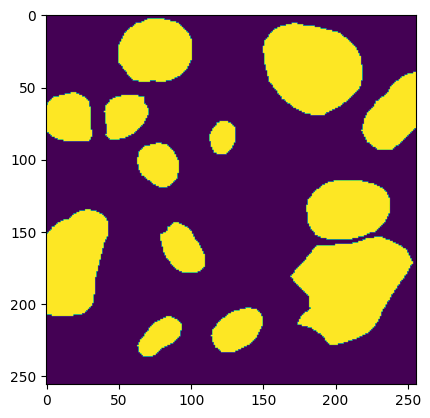

In [3]:
import cv2
import matplotlib.pyplot as plt

mask =  cv2.imread('/data1/zhangye/FCIS/data/PanNuke/test/5179_semantic.png', cv2.IMREAD_GRAYSCALE)
mask.shape
plt.imshow(mask)
plt.show()

In [ ]:
import shutil

for i in range(5179, 7901):
    shutil.copy(f'/data1/zhangye/FCIS/data/PanNuke/masks/test/{i}_s.png', f'/data1/zhangye/FCIS/data/PanNuke/masks/test/{i}.png')

In [15]:
import numpy as np
import cv2

ins1 = np.load('/data1/zhangye/FCIS/data/BBBC006/data256/mmseg/fcis_inst/test/mcf-z-stacks-03212011_a04_s1_0.npy')
ins1.shape

(256, 256)

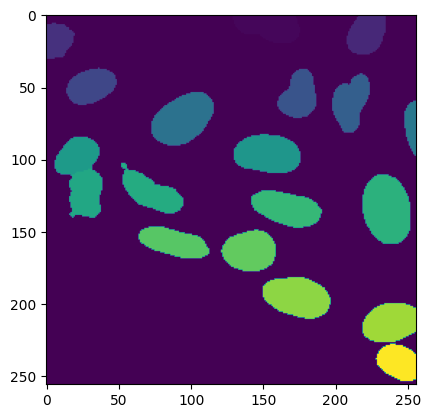

array([  0,   2,  13,  16,  24,  29,  34,  42,  45,  59,  61,  67,  69,
        72,  75,  83,  85,  93,  96, 112], dtype=uint8)

In [16]:
plt.imshow(ins1)
plt.show()
np.unique(ins1)

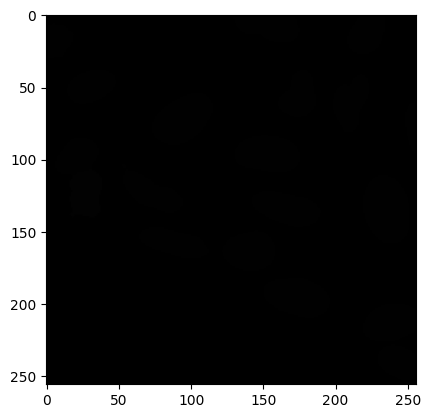

array([0, 1, 2], dtype=uint8)

In [12]:
import cv2
import matplotlib.pyplot as plt

mask =  cv2.imread('/data1/zhangye/FCIS/data/BBBC006/data256/mmseg/fcis_inst/test/mcf-z-stacks-03212011_a04_s1_0.png')
mask.shape
plt.imshow(mask)
plt.show()

np.unique(mask)

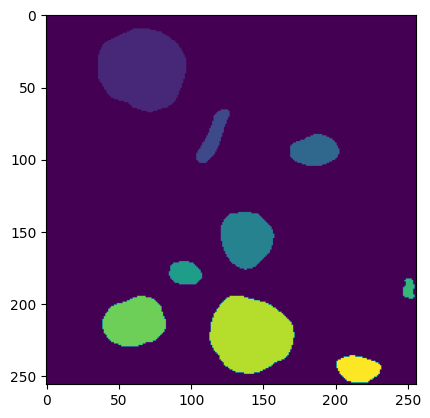

In [2]:
import numpy as np
import matplotlib.pyplot as plt

mask = np.load('/data1/zhangye/FCIS/zy_fcis_pannuke/instmap/5180.npy')
plt.imshow(mask)
plt.show()